**Machine Learning opdracht 3**

**namen:** Ruben de Winter, Tristan Hendriks, Rik van der Meer, Vinay Gobardhan

# 1. Inleiding

In deze opdracht onderzoeken wij hoe muziekgenres bepaald kunnen worden op basis van audiofragmenten, zonder vooraf te weten welke genres in de dataset aanwezig zijn. De kern van de opdracht is het toepassen van unsupervised learning op een verzameling geluidsfragmenten waarvan de genres onbekend zijn.

We beschikken over twee datasets: een gelabelde dataset met bekende genres en een unlabeled dataset waarvan het genre verborgen is. Het doel is om eerst te bepalen hoeveel muzikale groepen (clusters) er in de unlabeled dataset aanwezig zijn, en vervolgens te interpreteren om welke genres het waarschijnlijk gaat.

Om dit te kunnen doen, zetten we audio om in numerieke kenmerken (features), zoals spectral centroid, RMS, tempo en MFCC’s. Deze features beschrijven eigenschappen als klankkleur, energie en ritme. Met behulp van clusteringmodellen zoals KMeans en Agglomerative Clustering zoeken we vervolgens naar natuurlijke structuren in de data.

Naast het uitvoeren van unsupervised learning vergelijken we verschillende modellen en evalueren we de kwaliteit van de clusters met behulp van onder andere de silhouette score. Uiteindelijk vertalen we onze bevindingen naar een praktische toepassing in de vorm van een aanbevelingsapp, waarin nieuwe muziek automatisch kan worden gekoppeld aan vergelijkbare nummers.

Dit project combineert data-analyse, machine learning en systeemontwerp om inzicht te krijgen in hoe muziek akoestisch gestructureerd kan worden.

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (silhouette_score, davies_bouldin_score, classification_report, accuracy_score)
from sklearn.cluster import KMeans
from sklearn.cluster import  AgglomerativeClustering
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
from scipy.cluster.hierarchy import linkage, dendrogram
!pip install kneed==0.8.5

np.random.seed(42)

ModuleNotFoundError: No module named 'pandas'

## 1.1 Soorten data

De opdracht maakt gebruik van de volgende bestanden en mappen:
•	labeled data/: Bevat geluidsfragmenten waarvan het genre bekend is.
•	labels_new.csv: Bevat per geluidsbestand het bijbehorende genre.
•	unlabeled data/: Bevat geluidsfragmenten waarvan het genre niet bekend is.
•	sample_submission.csv: Voorbeeld van het formaat waarin de voorspellingen moeten worden ingeleverd.

De gelabelde dataset gebruiken we uitsluitend om clusters te interpreteren, niet om het clusteringmodel te trainen.

<hr>

# 2. Feature engineering

## 2.1 Waarom audiofeatures?

Machine learning modellen kunnen geen ruwe audio gebruiken. Daarom zetten we elk geluidsfragment om in een set numerieke kenmerken, zogenaamde audiofeatures. Deze kenmerken beschrijven eigenschappen zoals toonhoogte, energie en ritme.

Voor elk fragment gebruiken we de eerste 30 seconden audio en berekenen we per feature het gemiddelde over de tijd. Zo krijgt elk fragment één vaste featurevector.

## 2.2 Uitleg features

Librosa is een manier om muziek te analyseren\. Het haalt features uit de muziek om dingen uit de muziek te kunnen achterhalen\. Dit is erg belangrijk voor ons om goed de muziek te kunnen analyseren\. Hieronder leggen we uit wat elke feature inhoud die bij librosa passen\.

__Spectrale features:__ Zijn de eigenschappen waaruit de audio bestaat. Deze bevatten bijvoorbeeld informatie over de toon (hoog of laag), helderheid en variate van de audio. Door het uitvoeren van de Fourier transformatie is het mogelijk om deze verschillende spectral features te verkrijgen.



__Melspectogram:__ Laat zien hoe hard elke toon klink over tijd, maar aangepast naar de mel schaal zodat dit beter representeert hoe een mens het hoort. Dit doet de mel schaal door eerst de Fourier transform toe te passen en deze daarna om te zetten van 'hertz'--> 'mels'. 
De gebruikte formule is als volgt, hoge hertz worden hier harder gestraft. 

$$
m = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)
$$


Bron Formule: [Mel scale](https://grokipedia.com/page/Mel_scale)




__mfcc:__ mfcc zijn geluidsfeatures die kijken naar de timbre oftewel klankkleur van een geluidsfragment, hierbij wordt niet gekeken naar de toonhoogte van de audio (Geeksforgeeks, 2025). In onze opdracht hebben wij gekeken naar de eerste 5 coefficienten. Deze coefficienten zeggen elk iets over de audio. MFCC 1 omschrijft meer algemeen de timbre en elke mfcc 2 omschrijft de hoge vs lage frequentie verdeling en elke mfcc daarna zegt steeds iets specifiekers over de audio (Geeksforgeeks, 2025).

De mfcc wordt berekent door de zelfde stappen te doorlopen als bij het verkrijgen van het melspectogram waarna je Discrete Cosine Transform (DCT) uitvoert. 
stappen: Audio opdelen in kleinere stukken, tranformeren met Fourier, MEL filter berekenen en daarna DCT uitvoeren (Geeksforgeeks, 2025). 


__Root-Mean-Square (Energy):__  De RMS neemt het kwadraat van de audio (zodat negatieve waarden positief worden), hierna neemt hij het gemiddelde van de waardes en daarna neemt hij de wortel (Bos, 2013). DE RMS zegt hoe sterk een geluid voorkomt / hoe luid het is.



__Spectral centroid:__  De spectral centroid omschrijft de 'helderheid' van de audio, hoe groter het aandeel hoge frequenties hoe meer helder de audio is, het is een gewogen gemiddelde van de frequenties, waarbij de amplitudes bepalen hoeveel invloed elke frequentie heeft (Bos, 2013). verschillende instrumenten hebben vaak een verschillende helderheid, met de spectral centroid kan een algoritme deze onderscheiden.
$$
\text{Centroid} = \frac{\sum_{n=0}^{N-1} f(n) \cdot x(n)}{\sum_{n=0}^{N-1} x(n)}
$$

Bron formule: [Spectral centroid](https://studenttheses.uu.nl/bitstream/handle/20.500.12932/15175/scriptie.pdf?sequence=2)



__Spectral bandwidth:__ Geeft weer hoe verspreid  de energie is rondom de centroid. Een hogere bandwidth wilt betekenen dat er een grotere variatie aan frequenties aanwezig zijn. Je kunt het zien als een soortvan standaard deviatie van de energie. Deze wordt opnieuw ook gewogen met de amplitude. 
$$
\text{Spectral Bandwidth} = \left( \sum_{k} S[k, t] \cdot (f[k, t] - \text{centroid}[t])^p \right)^{1/p}
$$



Bron formule: [librosa.feature.spectral_bandwidth.](https://librosa.org/doc/main/generated/librosa.feature.spectral_bandwidth.html)

__Spectral rolloff:__ Is de frequentie in je data waarbij 85% van de energie onder het snijpunt valt, dit is een gewogen gemiddelde van amplitude en frequentie wat betekend dat frequenties met lage amplitude minder meetellen voor deze waarde (Bos, 2013). Als de rolloff hoog is kun je constateren dat er veel hoge frequenties in de audio voorkomen, ook kun je stellen dat het grootste gedeelte van je audio onder deze frequentie zit.




__Zero-Crossings_rate:__ De Zero-Crossing_rate is een maat voor de hoeveelheid ruis die in een audiofragment zit, deze maat word bepaald door de hoeveelheid keren dat de geluidsgolf door de x-as kruist per tijdeenheid in percentage (Bos, 2013; Librosa development team, z.d.-B).




__Tempo:__ Toont het tempo van de audio, oftewel de beats per minute (librosa development team, z.d.-C).



## 2.3 Functies maken voor feature extraction

In [ ]:
def extract_audio_features(
    file_path: str,
    duration: float = 30.0,
    sr: int = 22050,
    n_mfcc: int = 5,
) -> Dict[str, float]:
    signal, sampling_rate = librosa.load(file_path, sr=sr, duration=duration)

    features: Dict[str, float] = {}
    features["spectral_centroid"] = float(
        np.mean(librosa.feature.spectral_centroid(y=signal, sr=sampling_rate)))
    features["spectral_bandwidth"] = float(
        np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=sampling_rate)))
    features["spectral_rolloff"] = float(
        np.mean(librosa.feature.spectral_rolloff(y=signal, sr=sampling_rate)))
    features["zero_crossing_rate"] = float(
        np.mean(librosa.feature.zero_crossing_rate(signal)))
    features["rms"] = float(np.mean(librosa.feature.rms(y=signal)))

    tempo = librosa.beat.tempo(y=signal, sr=sampling_rate)[0]
    features["tempo"] = float(tempo)

    mfcc_values = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        features[f"mfcc_{i + 1}"] = float(np.mean(mfcc_values[i]))

    return features


def build_feature_dataframe(
    folder: str,
    filenames: List[str],
    duration: float = 30.0,
) -> pd.DataFrame:
    rows = []
    for fn in filenames:
        path = os.path.join(folder, fn)
        feats = extract_audio_features(path, duration=duration)
        feats["filename"] = fn
        rows.append(feats)

    return pd.DataFrame(rows)



## 2.4 Inladen van de data

In [ ]:
labels_df = pd.read_csv("labels_new.csv")

labeled_folder = "labeled data"
unlabeled_folder = "unlabeled data"

labeled_filenames = labels_df["filename"].tolist()
unlabeled_filenames = sorted(os.listdir(unlabeled_folder))

df_labeled = build_feature_dataframe(labeled_folder, labeled_filenames)
df_labeled = df_labeled.merge(labels_df, on="filename", how="left")

df_unlabeled = build_feature_dataframe(unlabeled_folder, unlabeled_filenames)

df_labeled.head()


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3183/4161268381.py:20: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=signal, sr=sampling_rate)[0]
/tmp/ipykernel_3183/4161268381.py:20: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=signal, sr=sampling_rate)[0]


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,filename,genre
0,2656.165734,2337.227557,5325.867795,0.158776,0.113753,107.666016,-75.517517,81.911423,-22.081081,69.876999,-11.740438,m00248.wav,metal
1,3760.424487,3053.066772,7442.646662,0.212375,0.096312,123.046875,-89.736382,36.286201,11.469535,37.495590,9.199136,m00230.wav,country
2,2290.107318,2181.589027,4819.512524,0.113229,0.102282,107.666016,-122.780525,95.061287,-29.363251,46.780045,-15.998561,m00637.wav,hiphop
3,2378.392048,2092.439557,4748.562953,0.141317,0.131590,123.046875,-57.683388,101.432327,-41.485245,55.130600,-23.349279,m00627.wav,metal
4,1995.600515,2295.466240,4557.697440,0.070323,0.078412,123.046875,-198.632797,102.413582,-10.031449,30.802383,-3.310606,m00138.wav,reggae


In [ ]:
print(len(unlabeled_filenames))


105


# 3. Exploratory Data Analysis (EDA)

We bekijken de data globaal om inzicht te krijgen in verdelingen, uitschieters en relaties tussen features.


## 3.1 Verdeling genres (labeled)

In de grafiek is te zien dat elk genre precies vijf keer voorkomt in de labeled dataset. De dataset is dus volledig gebalanceerd. Dit is prettig, omdat het betekent dat geen enkel genre dominant aanwezig is. Wanneer we later clusters koppelen aan genres via majority vote, wordt de interpretatie daardoor eerlijker en minder gevoelig voor vertekening. We kunnen de labeled data dus betrouwbaar gebruiken om clusters te interpreteren.


## 3.2 Correlaties tussen features

In de correlatieheatmap zien we dat verschillende spectral features sterk met elkaar samenhangen. Zo zijn spectral centroid, spectral rolloff en spectral bandwidth bijna perfect positief gecorreleerd. Dit betekent dat deze features grotendeels dezelfde informatie bevatten over de frequentieverdeling van het geluid. Ook zien we dat sommige MFCC-coëfficiënten sterk negatief correleren met deze spectral features.

Voor clustering is dit belangrijk, omdat algoritmes zoals KMeans werken met afstanden. Wanneer meerdere features vrijwel hetzelfde meten, kan die informatie zwaarder meewegen in de afstandsberekening. Daarom schalen we de features en onderzoeken we later met PCA of de data ook met minder dimensies goed te beschrijven is. We behouden de features voorlopig, maar houden in gedachten dat er overlap in informatie aanwezig is.



## 3.3 Boxplots van de features

De boxplots laten zien dat de verschillende features sterk uiteenlopende schalen hebben. Zo liggen spectral rolloff en centroid in de duizenden, terwijl zero crossing rate rond kleine decimalen ligt. Zonder schaalcorrectie zouden features met grotere waarden automatisch meer invloed hebben op de clustering.

Daarnaast zien we enkele uitschieters in de spectral features. Omdat clustering gebaseerd is op afstanden, kunnen zulke uitschieters de positie van centroids beïnvloeden. Om dit te voorkomen standaardiseren we alle features met een StandardScaler. Op deze manier zorgen we ervoor dat iedere feature een vergelijkbare invloed heeft op het model.

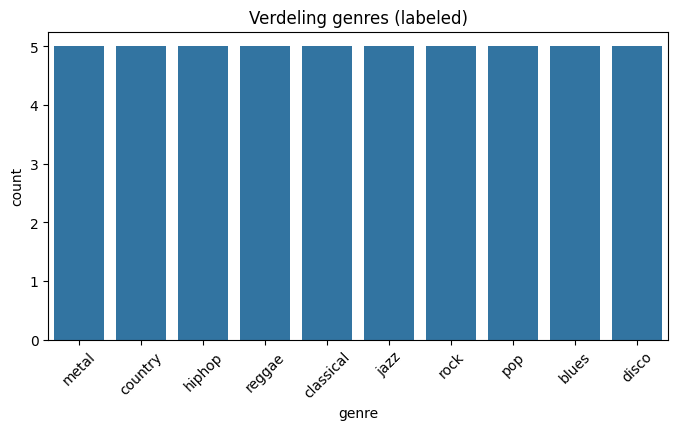

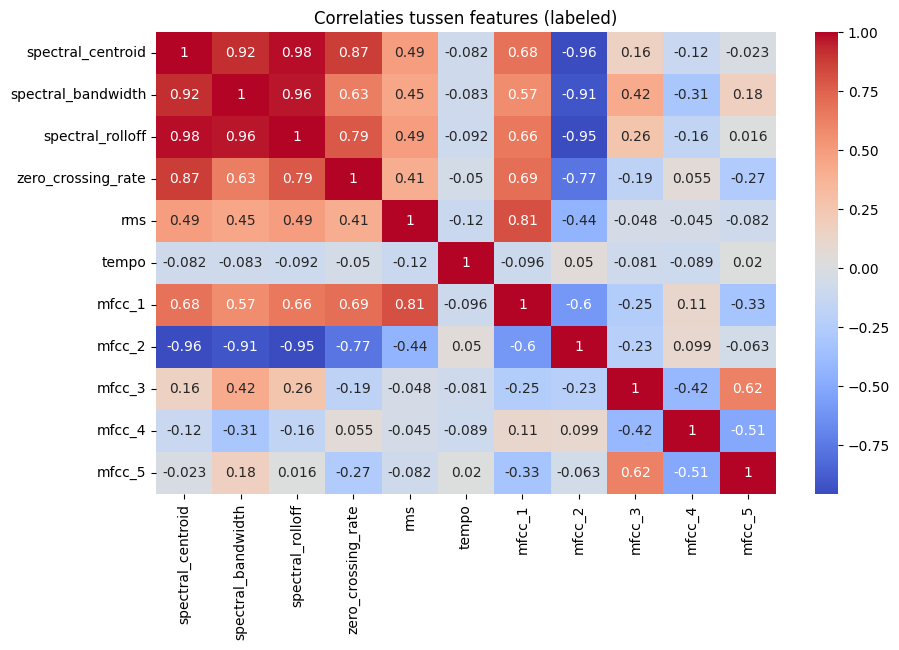

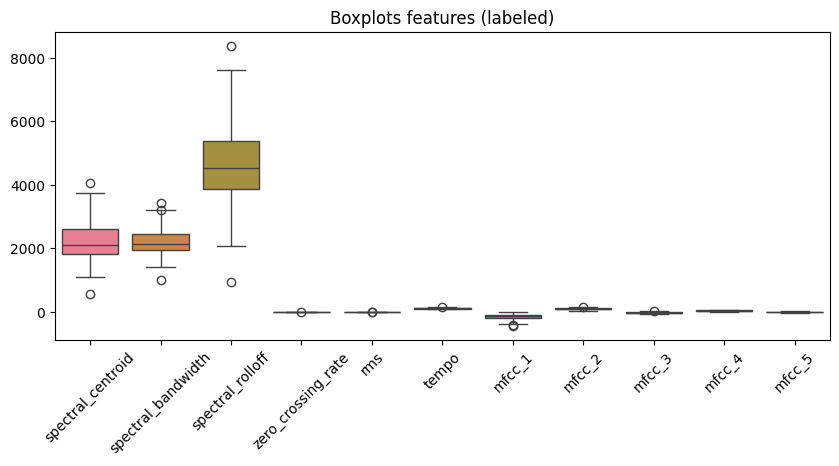

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_labeled, x="genre")
plt.xticks(rotation=45)
plt.title("Verdeling genres (labeled)")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_labeled.drop(columns=["filename", "genre"]).corr(), cmap="coolwarm", annot=True)
plt.title("Correlaties tussen features (labeled)")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_labeled.drop(columns=["filename", "genre"]))
plt.xticks(rotation=45)
plt.title("Boxplots features (labeled)")
plt.show()



## 3.4 Verdeling van individuele features

In bovenstaande histogrammen zien we hoe de waarden van iedere feature verdeeld zijn binnen de labeled dataset. De spectral features (centroid, bandwidth en rolloff) liggen grofweg in hogere numerieke ranges en vertonen een redelijk brede spreiding. Dit bevestigt dat verschillende fragmenten duidelijk verschillen in frequentieverdeling en helderheid.

De zero crossing rate en RMS laten kleinere waardes zien, maar ook hier is spreiding aanwezig. Dit suggereert dat sommige fragmenten meer ruis of energie bevatten dan andere. Tempo lijkt redelijk geconcentreerd rond een aantal waarden, wat logisch is omdat muziek vaak binnen bepaalde BPM-bereiken valt.

Bij de MFCC-coëfficiënten zien we zowel negatieve als positieve waarden en een duidelijke variatie per coefficient. Dit is verwacht, aangezien MFCC’s de klankkleur (timbre) samenvatten en dus sterk kunnen verschillen tussen genres.

Wat opvalt is dat geen enkele feature volledig constant is of extreem scheef verdeeld. Dit betekent dat iedere feature in principe informatie bijdraagt aan het onderscheiden van fragmenten. Tegelijkertijd zien we duidelijke verschillen in schaal en spreiding, wat opnieuw bevestigt dat standaardisatie noodzakelijk is voordat we clustering toepassen.

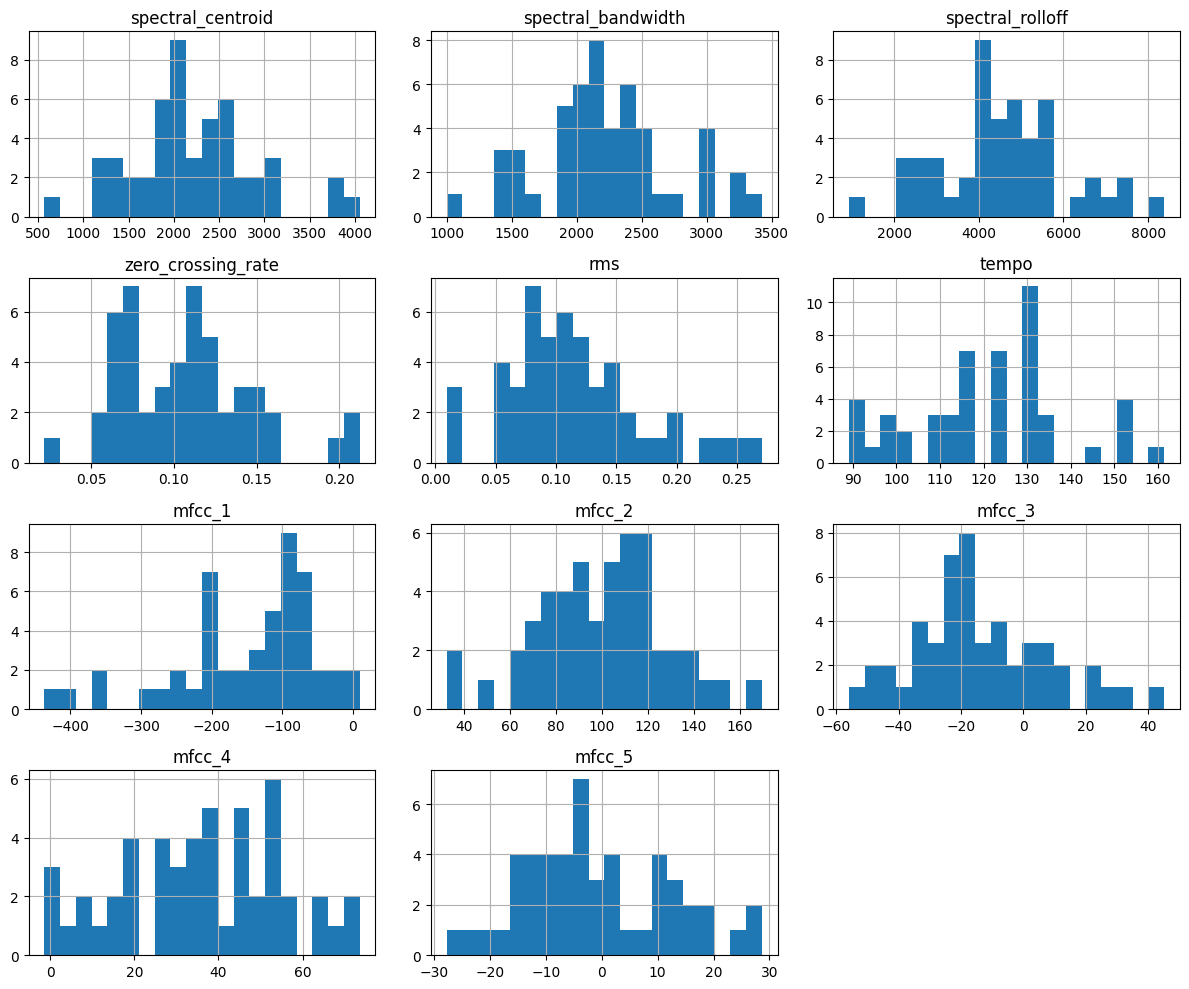

In [ ]:
df_labeled.drop(columns="genre").hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

## 3.5 Tempo per genre

In de boxplot van tempo per genre zien we dat sommige genres duidelijk verschillende tempo-bereiken hebben, terwijl andere elkaar deels overlappen. Zo lijkt reggae gemiddeld wat hogere tempo’s te hebben dan bijvoorbeeld hiphop of pop, terwijl jazz juist een grotere spreiding vertoont. Blues en disco laten eveneens een bredere variatie zien.

Toch is er ook aanzienlijke overlap tussen genres. Dit betekent dat tempo op zichzelf niet voldoende is om genres volledig van elkaar te onderscheiden. Wel kan tempo in combinatie met andere features bijdragen aan een beter onderscheid tussen clusters. Tempo nemen we daarom mee als onderdeel van de feature-set, maar we verwachten niet dat deze feature alleen doorslaggevend zal zijn.

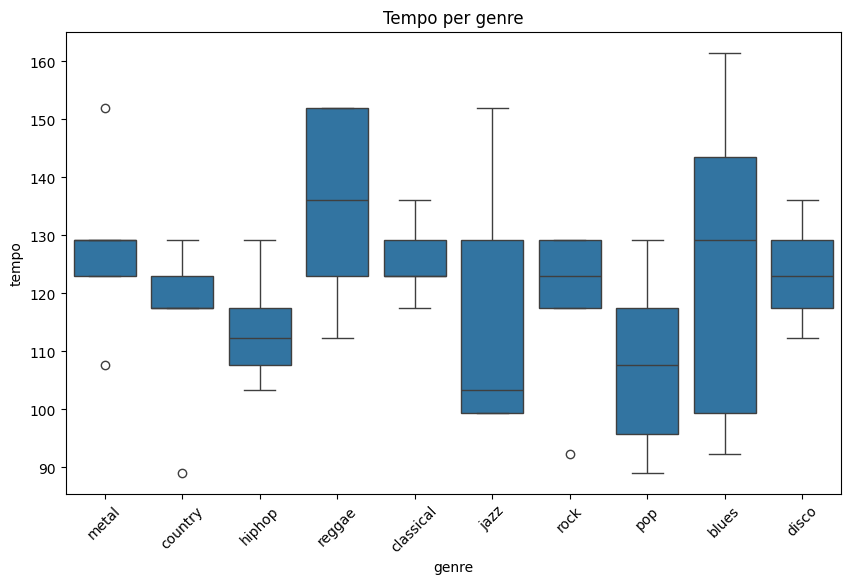

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_labeled, x="genre", y="tempo")
plt.xticks(rotation=45)
plt.title("Tempo per genre")
plt.show()


## 3.6 Tempo vs RMS per genre

In de scatterplot waarin tempo wordt afgezet tegen RMS (energie), zien we dat sommige genres zich enigszins groeperen, maar dat er ook duidelijke overlap aanwezig is. Fragmenten met hogere energie (hogere RMS) bevinden zich vaak in het midden- tot hogere tempo-bereik, maar dit geldt niet exclusief voor één genre.

Dit bevestigt dat muziekgenres niet strikt gescheiden zijn op basis van één of twee kenmerken. De combinatie van meerdere features, zoals spectral eigenschappen en MFCC-coëfficiënten, is nodig om onderscheid te maken. Voor clustering betekent dit dat het model meerdere dimensies tegelijk moet gebruiken om patronen te herkennen.

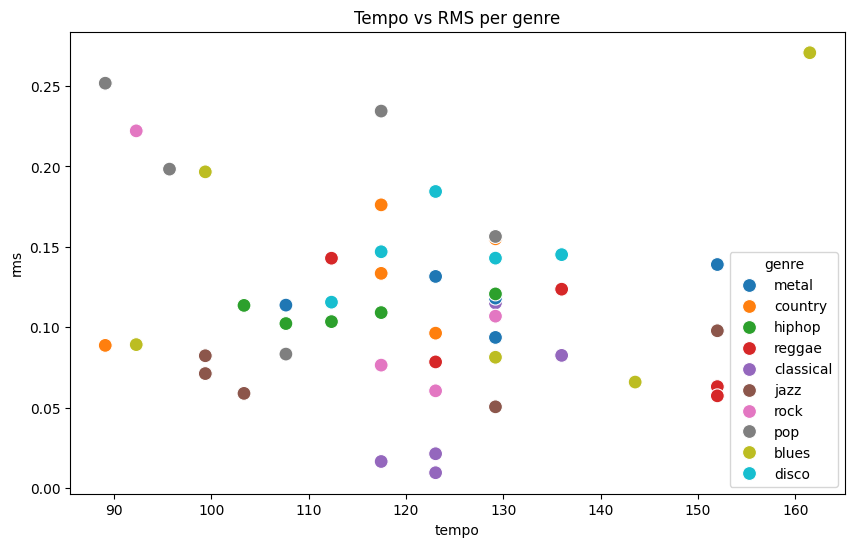

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_labeled, x="tempo", y="rms", hue="genre", palette="tab10", s=100)
plt.title("Tempo vs RMS per genre")
plt.show()


Visualisatie

# 4\. Schalen van de data

Omdat de features verschillende schalen hebben, standaardiseren we de data met StandardScaler\.

In [ ]:
feature_cols = [c for c in df_labeled.columns if c not in ["filename", "genre"]]

scaler = StandardScaler()
X_labeled = scaler.fit_transform(df_labeled[feature_cols])
X_unlabeled = scaler.transform(df_unlabeled[feature_cols])

print("X_unlabeled shape:", X_unlabeled.shape)

X_unlabeled shape: (105, 11)


# 5. Bepalen van aantal clusters

Omdat het genre van de unlabeled dataset onbekend is, moeten we eerst bepalen hoeveel clusters (k) waarschijnlijk aanwezig zijn in de data. Dit is een cruciale stap binnen unsupervised learning: een verkeerde keuze voor k leidt tot onder- of oversegmentatie van de muziekgenres.

Om tot een onderbouwde keuze te komen combineren we vier methodes:
	1.	De elleboogmethode (inertia)
	2.	De silhouette score
	3.	De Kneedle-methode (automatische knikdetectie)
	4.	Een praktische validatie met de gelabelde dataset

Door deze methodes samen te gebruiken voorkomen we dat we blind vertrouwen op één maat.


## 5.1 Elleboog methode (Inertia)
De inertia meet hoe compact de clusters zijn. Hoe lager de inertia, hoe dichter de punten bij hun clustercentrum liggen.
Wanneer we k verhogen, daalt de inertia altijd, omdat de data in kleinere groepen wordt verdeeld. De vraag is dus niet óf de inertia daalt, maar wanneer de extra verbetering klein wordt.

In de grafiek zien we dat de sterke daling rond k = 3 tot 5 afvlakt. Dit suggereert dat extra clusters na dit punt relatief weinig nieuwe structuur toevoegen. Inertia is echter geen perfecte maat: een model met meer clusters heeft altijd lagere inertia, maar dit betekent niet noodzakelijk dat de clusters betekenisvol zijn. Inertia kijkt alleen naar compactheid, niet naar hoe goed clusters van elkaar gescheiden zijn.

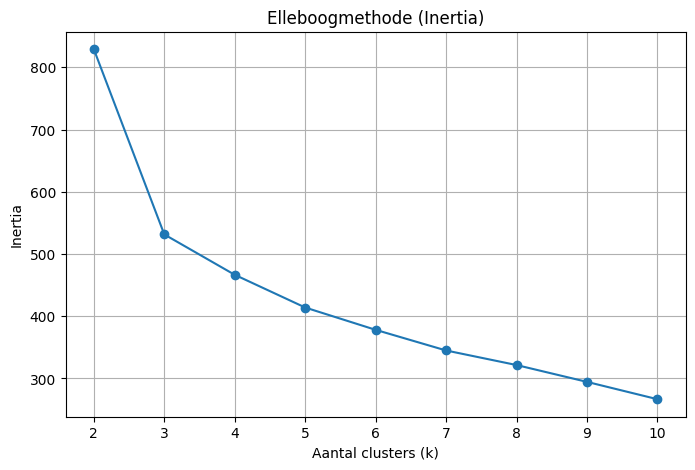

In [ ]:
k_values = range(2, 11)
inertia_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_unlabeled)
    inertia_scores.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_scores, marker="o")
plt.xlabel("Aantal clusters (k)")
plt.ylabel("Inertia")
plt.title("Elleboogmethode (Inertia)")
plt.grid(True)
plt.show()

### 5.1.1 Interpretatie Elleboogmethode (Inertia)

In de grafiek zien we dat de inertia sterk daalt van k = 2 naar k = 3. Daarna neemt de daling geleidelijk af. Vanaf ongeveer k = 4 of k = 5 wordt de lijn duidelijk vlakker.

Dit betekent dat het toevoegen van extra clusters na dit punt relatief weinig verbetering oplevert. De grootste winst in compactheid wordt dus behaald bij lage k-waarden, waarna de meerwaarde per extra cluster kleiner wordt.

Op basis van deze grafiek ligt het optimale gebied rond k = 3 tot 5.

## 5.2 Silhouette score

De silhouette score meet, in tegenstelling tot inertia, wel hoe goed clusters gescheiden zijn.

Voor elk punt wordt gekeken:
•	Hoe dicht ligt het bij zijn eigen cluster?	
•	Hoe ver ligt het van andere clusters?

De score ligt tussen -1 en 1. Hoe hoger, hoe beter de scheiding.

In onze analyse is de hoogste silhouette score bij k = 2.
Toch achten we twee clusters niet realistisch voor muziekgenres. Daarom gebruiken we silhouette als richtlijn, maar niet als enige beslissingscriterium.

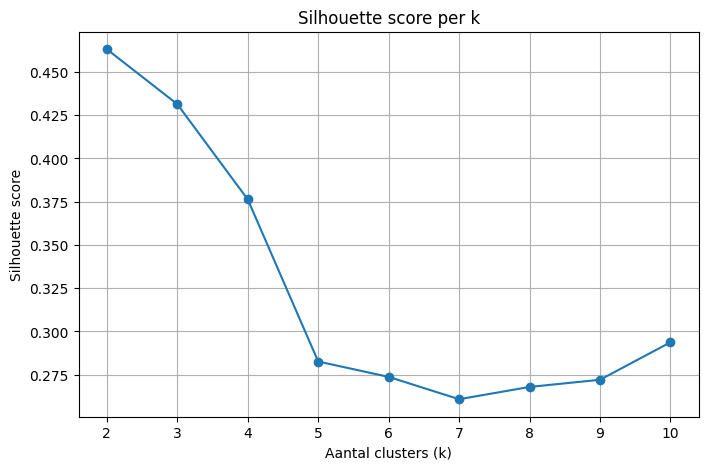

In [ ]:
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_unlabeled)
    score = silhouette_score(X_unlabeled, labels)
    silhouette_scores.append(score)


plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("Aantal clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score per k")
plt.grid(True)
plt.show()

### 5.2.1 Interpretatie Silhouette score

De silhouette score is het hoogst bij k = 2 (ongeveer 0.46). 
Daarna daalt de score duidelijk bij hogere k-waarden en stabiliseert rond 0.275 voor k = 5.

Dit betekent dat de clusters bij k = 2 het meest duidelijk van elkaar gescheiden zijn. Toch achten we twee clusters niet realistisch voor muziekgenres, aangezien de dataset waarschijnlijk meerdere genres bevat.

Hoewel de silhouette score afneemt bij hogere k, blijft de score rond k = 5 stabiel en positief. Dit wijst op redelijke clusterstructuur, ondanks enige overlap tussen genres.

## 5.3 Kneedle-methode

De Kneedle-methode detecteert automatisch het knikpunt in een grafiek.
•	Op basis van silhouette → k = 2
•	Op basis van inertia → k = 3

Beide wijzen naar een bereik tussen 3 en 5 clusters. Dit bevestigt dat het optimale aantal waarschijnlijk in dit gebied ligt.

In [ ]:
kneedle_sil = KneeLocator(
    k_values,
    silhouette_scores,
    curve="convex",
    direction="decreasing")

kneedle_inertia = KneeLocator(
    k_values,
    inertia_scores,
    curve="convex",
    direction="decreasing")

print("Kneedle (silhouette) suggereert k =", kneedle_sil.knee)
print("Kneedle (inertia) suggereert k =", kneedle_inertia.knee)

Kneedle (silhouette) suggereert k = 5
Kneedle (inertia) suggereert k = 3


### 5.3.1 Interpretatie Kneedle-methode

De Kneedle-analyse geeft twee verschillende suggesties:
•	Op basis van de silhouette score wordt k = 5 voorgesteld.
•	Op basis van de inertia wordt k = 3 voorgesteld.

Dit verschil is verklaarbaar. Inertia meet alleen hoe compact clusters zijn. Naarmate k toeneemt, worden clusters automatisch compacter. De methode zoekt daarom het punt waar extra clusters weinig extra winst opleveren. Dat punt ligt hier rond k = 3.

De silhouette score kijkt niet alleen naar compactheid, maar ook naar hoe goed clusters van elkaar gescheiden zijn. Dat k = 5 hier als beste waarde naar voren komt, betekent dat bij vijf clusters de balans tussen interne samenhang en onderlinge afstand het meest optimaal is.

## 5.4 Validatie met gelabelde data

We controleren hoe goed clusters overeenkomen met echte genres.
We clusteren de data zonder gebruik te maken van de labels en kijken vervolgens hoe goed de clusters overeenkomen met de echte genres via een majority vote per cluster. Daarna berekenen we de accuracy.

Hogere k-waarden geven vaak hogere accuracy.
Maar dit kan betekenen dat één genre in meerdere clusters wordt opgesplitst.

In [ ]:
def build_cluster_to_genre_map(cluster_labels, genres):
    """
    Maak een mapping van cluster_id -> genre op basis van majority vote.
    Voor elk cluster pakken we het genre dat het vaakst voorkomt in de gelabelde data.
    """
    df_map = pd.DataFrame({"cluster": cluster_labels, "genre": genres})
    return (
        df_map.groupby("cluster")["genre"]
        .agg(lambda x: x.value_counts().idxmax())
        .to_dict())


def apply_cluster_to_genre(cluster_labels, mapping):
    """Vertaal clusterlabels naar genrelabels via de mapping."""
    return np.array([mapping.get(int(c), "unknown") for c in cluster_labels], dtype=object)


scores_k = []

# Combineer labeled + unlabeled zodat clustering dezelfde 'ruimte' ziet
X_combined = np.vstack([X_labeled, X_unlabeled])
n_labeled = len(X_labeled)

for k in range(2, 11):
    model = AgglomerativeClustering(n_clusters=k)
    combined_clusters = model.fit_predict(X_combined)

    labeled_clusters = combined_clusters[:n_labeled]

    # genre op basis van majority vote in labeled data
    mapping = build_cluster_to_genre_map(labeled_clusters, df_labeled["genre"])

    y_true = df_labeled["genre"].to_numpy()
    y_pred = apply_cluster_to_genre(labeled_clusters, mapping)

    # Meet hoe goed clusters overeenkomen met echte genres
    acc = accuracy_score(y_true, y_pred)

    scores_k.append({
        "k": k,
        "mapping_accuracy_labeled": acc,
        "n_clusters_found": len(np.unique(labeled_clusters))})

mapping_table = (
    pd.DataFrame(scores_k)
    .sort_values("mapping_accuracy_labeled", ascending=False)
    .reset_index(drop=True))

mapping_table

,k,mapping_accuracy_labeled,n_clusters_found
0,9,0.48,9
1,10,0.48,9
2,8,0.46,8
3,6,0.44,6
4,7,0.44,7
5,5,0.40,5
6,4,0.36,4
7,3,0.30,3
8,2,0.20,2


### 5.4.1 Interpretatie validatie met gelabelde data

De mapping-accuracy neemt toe naarmate k groter wordt. Dit is te verwachten, aangezien meer clusters zorgen voor een fijnere onderverdeling van de data, waardoor genres makkelijker afzonderlijk geïdentificeerd kunnen worden.

Bij k = 9 en k = 10 wordt de hoogste accuracy (0.48) behaald. Dit betekent echter niet automatisch dat er 9 of 10 genres aanwezig zijn in de dataset. Een hogere k-waarde kan leiden tot het opsplitsen van één genre in meerdere subclusters.

Daarom gebruiken wij deze analyse als aanvullende validatie, maar baseren wij onze definitieve keuze voornamelijk op de inertia- en silhouette-analyse.

## 5.5 Definitieve keuze

Hoewel k = 3 volgens inertia voldoende compactheid biedt, kiezen wij voor k = 5.

De redenen hiervoor zijn:
•	De silhouette score houdt rekening met zowel compactheid als scheiding.
•	Muziekgenres overlappen sterk; extra clusters kunnen subtielere verschillen opvangen.
•	k = 5 levert een realistischer segmentatie op dan k = 3.
•	Het verschil in inertia tussen k = 3 en k = 5 is beperkt.

Daarom gebruiken wij k = 5 in de verdere clusteringanalyse.

In [ ]:
k_final = 5
print("Definitief gekozen k_final =", k_final)

Definitief gekozen k_final = 5


# 6 Clustering algoritmes
Na het bepalen van het optimale aantal clusters (k = 5) passen we verschillende clusteringalgoritmes toe op de geschaalde dataset. Het doel is om te onderzoeken welk model de meest logische en stabiele groepering van muziekfragmenten oplevert.

We vergelijken drie modellen:
•	KMeans
•	Agglomerative Clustering
•	DBSCAN

## 6.1 KMeans

KMeans is een clustering model die volgens zijn naam een K-aantal clusters maakt. Het doel van het model is a.o. om te vinden hoeveel clusters er bestaan in je data, dit is dus nuttig voor onze opdracht aangezien wij niet weten hoeveel genres er zijn in de unlabeled data.

Om erachter te komen wat het optimale aantal clusters is voor het KMeans model kunnen we de elleboog methode toepassen. Hieronder voeren we die uit in combinatie met de Silhouette score en Kneed. Een reden voor het toepassen van deze methode is dat we het model niet te complex willen maken en meer clusters aanmaken dan in de realiteit voorkomt (Geelen, 2023). De elleboog methode kan overfitting voorkomen.

__inertia:__ Inertia is de hoeveelheid fout (sum) dat de datapunten van elk cluster hebben, dit wordt standaard berekent met de 'euclidean distance'(Scikit-learn, z.d.). Hierbij wordt echter niet echt rekening gehouden met het duidelijk gescheid houden van elk cluster. Een laag inertia betekend weinig spreiding --> goed

__Silhouette:__ De silhouette score meet hoe goed de datapunten passen binnen hun clusters, vergeleken met andere clusters (Geelen, 2023). Hiermee vergelijkt het met de 'euclidean distance' de gemiddelde afstand van een cluster van zichzelf (de spreiding eigenlijk) met de gemiddelde afstand van het cluster naar een ander cluster (Geelen, 2023). Waar silhouette verschilt met __inertia__ is dat ook kijkt naar de kwaliteit, wat wil zeggen dat de clusters ook een duidelijke distinctie/afstand moeten hebben van elkaar. De silhouette score standaardiseert de uitkomst tussen -1 en 1, waarbij 1 een hoge score is met duidelijke clusters die goed gescheiden zijn (Geelen, 2023).


Bron Silhoutte formule (voor individuele datapunten):[Scikit-learn. (z.d.)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
a = afstand binnen cluster
b = afstand tot ander cluster
Max(a/b) = alleen hoogste getal word genomen in de breuk
$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

__Kneed:__ Kneed is een functie die goed samengaat met de elleboog methode. Een nadeel aan de elleboog methode kan zijn dat het niet duidelijk is waar precies de elleboog (het optimale cluster aantal) zit. Kneed kan de optimale elleboog vinden, maar werkt soms minder goed voor complexe curves(Geelen, 2023; Arvai, 2023). 

## 6.2 Vinden van optimaal aantal n_clusters met silhouette en kneed


## 6.2.1 silhouette + kneed

---------------------------------------------
Optimale Knee gevonden door Kneed (optimale k): 5


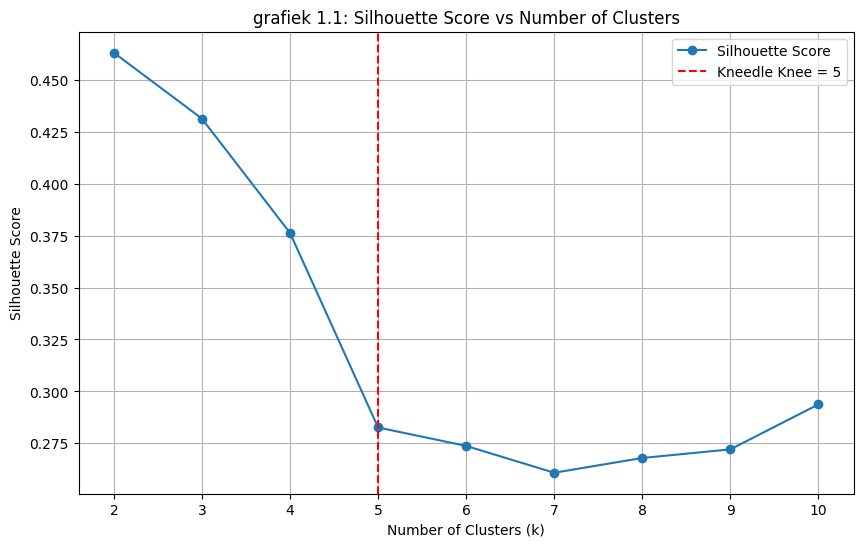

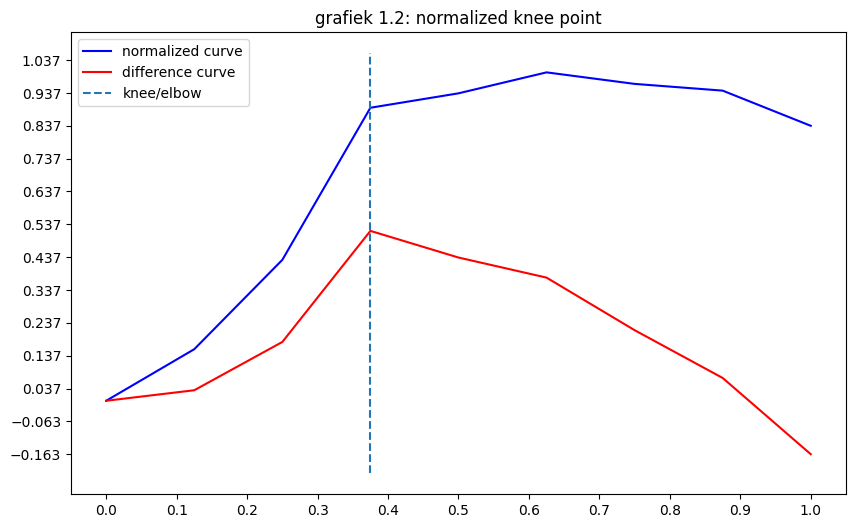

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import matplotlib.pyplot as plt

# lijst met silhouette scores voor clusters 1-10
k_values = range(2, 11) 

silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_unlabeled)  
    score = silhouette_score(X_unlabeled, cluster_labels)
    silhouette_scores.append(score)


# vind optimale knee gebasseerd op silhouette score
kneedle = KneeLocator(k_values, silhouette_scores, curve='convex', direction='decreasing')
print(f'---------------------------------------------')
print("Optimale Knee gevonden door Kneed (optimale k):", kneedle.knee)

# plot silhouette score voor elke cluster hoeveelheid
plt.figure(figsize=(10,6))
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.axvline(kneedle.knee, color="red", linestyle="--", label=f"Kneedle Knee = {kneedle.knee}")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('grafiek 1.1: Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

# normalized knee point plot
kneedle.plot_knee_normalized(figsize=(10,6), title = 'grafiek 1.2: normalized knee point')

## 6.2.2 inertia + kneed

---------------------------------------------
Optimale Knee gevonden door Kneed (optimale k): 3


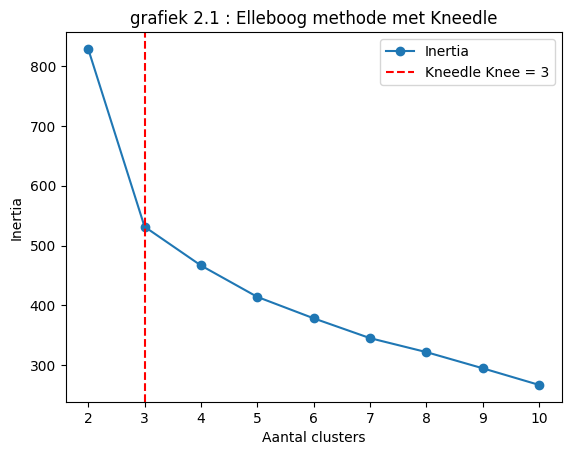

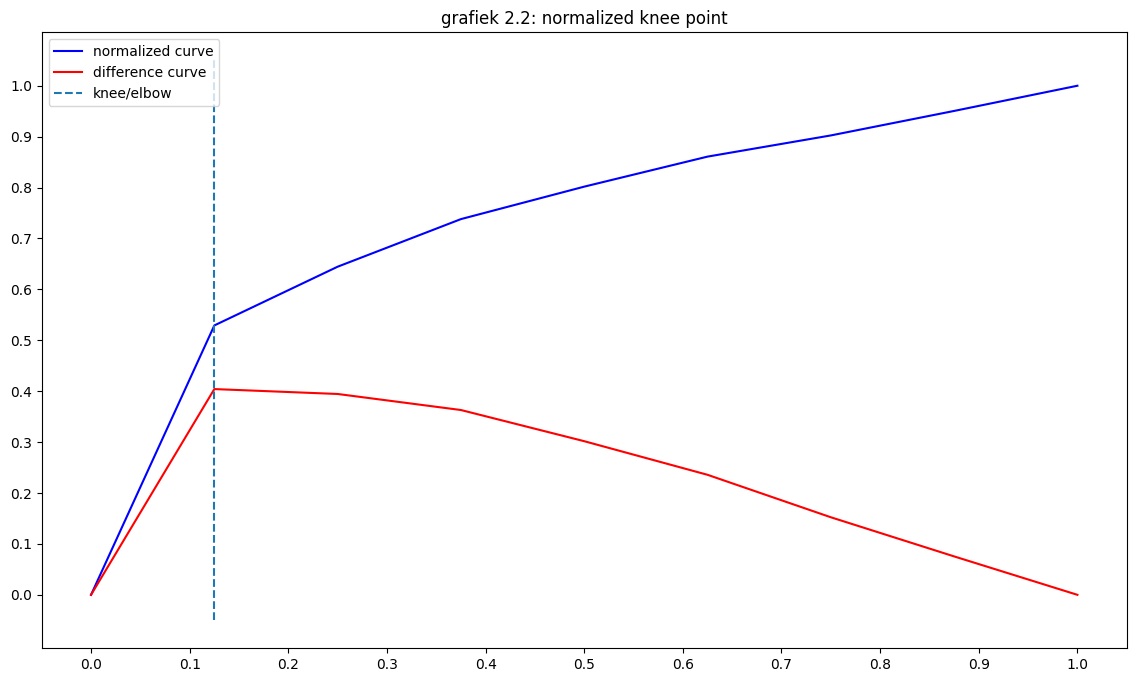

In [ ]:
# Lijst met inertia scores voor clusters 1-10
K = range(2, 11)

inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_unlabeled)
    inertia.append(kmeans.inertia_)

# kneed toepassen voor elleboog
kneedle = KneeLocator(K, inertia, curve="convex", direction="decreasing")
elbow_k = kneedle.elbow
print(f'---------------------------------------------')
print("Optimale Knee gevonden door Kneed (optimale k):", kneedle.knee)

# plot inertia voor elke clusterhoeveelheid
plt.plot(K, inertia, marker='o', label='Inertia')
plt.axvline(x=elbow_k, color='red', linestyle='--', label=f'Kneedle Knee = {kneedle.knee}')
plt.xlabel("Aantal clusters")
plt.ylabel("Inertia")
plt.title("grafiek 2.1 : Elleboog methode met Kneedle")
plt.legend()
plt.show()

# 
kneedle.plot_knee_normalized(figsize=(14,8), title = 'grafiek 2.2: normalized knee point')



## 6.2.3 optimale elleboog (knee)

- Grafiek 1.1 en 2.1 weergeven het optimale aantal clusters voor het model gekozen gebasseerd op  respectievelijk silhouette score en inertia. 
- Grafiek 2.1 en 2.2 weergeven het tradoff dillema op een duidelijke wijze, de rode lijn geeft weer wat als het ware het nut is van een extra cluster, de grafiek is genormalizeerd en het optimale cluster zit bij het punt waarbij deze het hoogste zit (Geelen, 2023).

In eerste instantie valt het op dat bij grafiek 1.1 5 clusters optimaal is en dat bij grafiek 2.1 3 clusters optimaal is. Grafiek 1.1 heeft waarschijnlijk meer clusters dan 2.1 aangezien meer clusters ervoor zorgen dat de afstanden tussen cluster kleiner wordt en afstand binnen clusters ook verkleint, wat belangrijk is voor de silhouette score. 

Ten tweede valt op te merken dat de toegevoegde waarde van een extra cluster voor grafiek 1.1 vrij snel daalt terwijl voor grafiek 2.1 de toegevoegde waarde bijna gelijk staat voor clusters 3-5.

Het doel voor onze opdracht is om te achterhalen welke genres voorkomen en deze juist te classificeren bij de audio bestanden. Hiermee is het belangrijk dat het model duidelijk onderscheid kan maken tussen deze genres. Muziek heeft best wel wat overlap en het juist classificeren kan daardoor moeilijk zijn. Wij vinden dat __de silhouette score de beste maat is__ voor het achterhalen van het optimale aantal clusters, aangezien het rekening houdt met het differentieren van de clusters en kijkt naar de kwaliteit hiervan. Daarbovenop is de afname in inertia voor 5 clusters ook niet zodanig groot dat het overfitting suggereerd. 

__Het optimale aantal clusters is daarom 5__ 

###  6.2.4 werking algoritme:

Het algoritme werkt als volgt: eerst worden willekeurig vijf clustercentra geplaatst in de dataset. Vervolgens wordt elk muziekfragment toegewezen aan het dichtstbijzijnde centrum op basis van de Euclidische afstand. Daarna wordt voor elk cluster het nieuwe centrum berekend als het gemiddelde van alle punten in dat cluster. Dit proces herhaalt zich totdat de clusterindeling stabiel is.

Het doel van KMeans is om de variatie binnen clusters zo klein mogelijk te maken. Fragmenten binnen één cluster lijken dus sterk op elkaar in termen van klankkleur, energie en ritmische kenmerken.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_unlabeled)

sil_kmeans = silhouette_score(X_unlabeled, labels_kmeans)

print("Aantal clusters:", len(np.unique(labels_kmeans)))
print("Silhouette score:", sil_kmeans)

Aantal clusters: 5
Silhouette score: 0.2826333242656517


### 6.2.5 Interpretatie KMeans resultaat

Bij toepassing van KMeans met vijf clusters vinden we inderdaad vijf duidelijke groepen in de dataset. De silhouette score bedraagt ongeveer 0.28.

De silhouette score ligt tussen -1 en 1. Een score rond 0.28 betekent dat de clusters redelijk gescheiden zijn, maar dat er ook overlap aanwezig is tussen sommige groepen. Dit is in de context van muziek niet verrassend: genres delen vaak kenmerken zoals tempo, energie of klankkleur.

De score is positief en stabiel, wat betekent dat de clusters niet willekeurig zijn en dat het model daadwerkelijk structuur in de data heeft gevonden. Tegelijkertijd laat de relatief gematigde score zien dat muziekgenres geen scherp afgebakende categorieën zijn, maar eerder overlappende stijlen.

KMeans blijkt hiermee een bruikbaar model voor het groeperen van muziekfragmenten op basis van akoestische kenmerken.








#### uploaden K-mean resultaten naar kaggle (30% acc)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)

df_unlabeled["cluster"] = kmeans.fit_predict(X_unlabeled)
display(df_unlabeled)

kmeans_labeled = KMeans(n_clusters=5, random_state=42)
df_labeled["cluster_kmean"] = kmeans_labeled.fit_predict(X_labeled)

# Bepaal per cluster het meest voorkomende genre
cluster_to_genre = (
    df_labeled
    .groupby("cluster_kmean")["genre"]
    .agg(lambda x: x.value_counts().idxmax()))

print("Cluster → genre mapping:")
print(cluster_to_genre)

df_unlabeled["predicted_genre_KMeans"] = df_unlabeled["cluster"].map(cluster_to_genre)

display(df_unlabeled)

,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,filename,cluster
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,-3.283182,m00003.wav,0
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,-18.557953,m00012.wav,0
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,-12.745122,m00013.wav,3
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,-3.806012,m00043.wav,0
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,0.777301,m00044.wav,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,-10.287586,m00971.wav,3
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,9.721153,m00973.wav,2
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,3.778163,m00988.wav,2
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,7.907838,m00991.wav,1


Cluster → genre mapping:
cluster_kmean
0    classical
1      country
2          pop
3        metal
4       reggae
Name: genre, dtype: object


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,filename,cluster,predicted_genre_KMeans
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,-3.283182,m00003.wav,0,classical
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,-18.557953,m00012.wav,0,classical
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,-12.745122,m00013.wav,3,metal
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,-3.806012,m00043.wav,0,classical
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,0.777301,m00044.wav,1,country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,-10.287586,m00971.wav,3,metal
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,9.721153,m00973.wav,2,pop
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,3.778163,m00988.wav,2,pop
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,7.907838,m00991.wav,1,country


In [ ]:
# kaggle df
submit_df = df_unlabeled[["filename", "predicted_genre_KMeans"]].copy()

# Hernoem cluster kolom naar genre
submit_df.rename(columns={"predicted_genre_KMeans": "genre"}, inplace=True)

# delete spaties
submit_df["filename"] = submit_df["filename"].str.strip()
submit_df["genre"] = submit_df["genre"].str.strip()

display(submit_df.head())

# csv download 
submit_df.to_csv("Cleaned_submission.csv", index=False, header = True)

print(submit_df.shape)   # moet (105, 2) zijn
print(submit_df.columns)

,filename,genre
0,m00003.wav,classical
1,m00012.wav,classical
2,m00013.wav,metal
3,m00043.wav,classical
4,m00044.wav,country


(105, 2)
Index(['filename', 'genre'], dtype='object')


## 6.2 Agglomerative Clustering
Agglomerative Clustering is een hiërarchisch clustering-algoritme dat start met elke observatie als een apart cluster. Vervolgens worden in opeenvolgende stappen telkens de twee meest gelijkende clusters samengevoegd, totdat het gewenste aantal clusters is bereikt.

Het verschil met KMeans is dat Agglomerative geen clustercentra optimaliseert, maar een hiërarchische structuur opbouwt. De manier waarop clusters worden samengevoegd hangt af van het gekozen linkage-criterium, zoals:
•	single linkage: voegt de 2 clusters samen met de korste afstand tussen 2 punten, dit kan soms leiden tot een ketting achtig structuur https://www.youtube.com/watch?v=vg1w5ZUF5lA 
•	complete linkage: Voegt de 2 clusters samen met de langste afstand tussen 2 punten, het doel van de complete linkage is om de clusters zo rond mogelijk te houden https://www.youtube.com/watch?v=vg1w5ZUF5lA
•	average linkage: Voegt de 2 clusters samen met de kleinste gemiddelde afstand tussen alle punten van de clusters. https://www.youtube.com/watch?v=McY6b3Fuqm8 

In deze opdracht gebruiken wij standaard Euclidische afstand en average linkage, omdat dit meestal stabielere clusters oplevert dan single linkage.

Agglomerative Clustering is geschikt wanneer de structuur van de data onbekend is en wanneer een hiërarchische indeling gewenst is. Verder werkt Agglomerative clustering ook goed op datasets die minder groot zijn, terwijl KMeans en DBScan juist meer voordeel hebben aan een grotere dataset, hiermee is het handig om dit model uit te voeren (Avantikaroy, 2025).

###  6.2.1 Hoe wordt euclidean distance berekent? 

https://www.youtube.com/watch?v=7xHsRkOdVwo 

(Statquest, 2018)



Bij agglomerative clustering worden voor elk audio sample de waarden van de features vergeleken met die van andere samples. De samples die het dichtst bij elkaar liggen worden vervolgens samengevoegd tot clusters. Wij gebruiken de Euclidische afstand om te berekenen welke samples dicht bij elkaar liggen. De Euclidische afstand wordt berekend door
de feature aftanden van de 2 samples te kwadrateren, op te tellen en daarna de vierkantswortel hiervan te nemen (Statquest, 2018).



<img src="image-20260213-143731.png" width="" align="" />

###  6.2.2 Hoe werkt average linkage?


Formule die gebruikt wordt voor average linkage:   https://medium.com/@avantika10roy/agglomerative-clustering-explained-from-single-points-to-meaningful-groups-c2a6e3d4bdf6

<img src="image-20260213-142304.png" width="" align="" />

<img src="image-20260213-142338.png" width="" align="" />

### 6.2.3 Vinden van de optimale parameters  
average link formule = https://medium.com/@avantika10roy/agglomerative-clustering-explained-from-single-points-to-meaningful-groups-c2a6e3d4bdf6

Voor het vinden van het optimale aantal clusters voor het model gebruiken we een dendrogram en silhouette score. Het dendrogram geeft een visueel beeld van de hiërarchie tussen de clusters en laat zien wat de afstand tussen de toegevoegde clusters is. Dit is relevant aangezien dit laat zien wanneer het vormen van een nieuw cluster niet gewenst is, dit valt te zien door de grote sprongen tussen de nieuwe clusters. 
Echter zoals bij ons is het niet in 1 oogopzicht op te merken welk aantal clusters het beste past voor ons model. 



Dat is waar de silhouette score te pas komt. Deze werkt hier hetzelfde als bij Kmeans, de silhouette score geeft een duidelijke maat voor hoe goed een bepaald aantal clusters is voor ons model.

Zoals te zien in de visualisatie lijkt de elleboog op k=5 te zijn, wat wel apart is, is dat op k=6 de silhouette score stijgt ten opzichte van k=5, dit lijkt echter niet natuurlijk en is mogelijk niet representatief voor de test data.
Het optimale aantal clusters voor dit model lijkt ons daarom 5. 






<img src="image-20260213-142119.png" width="" align="" />

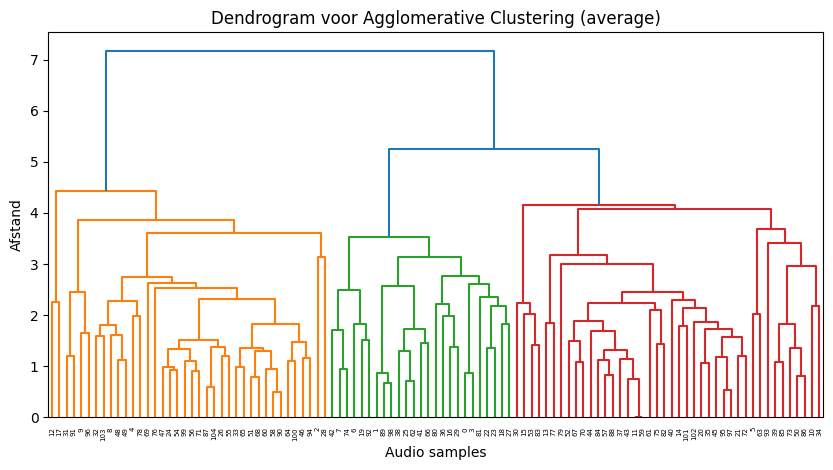

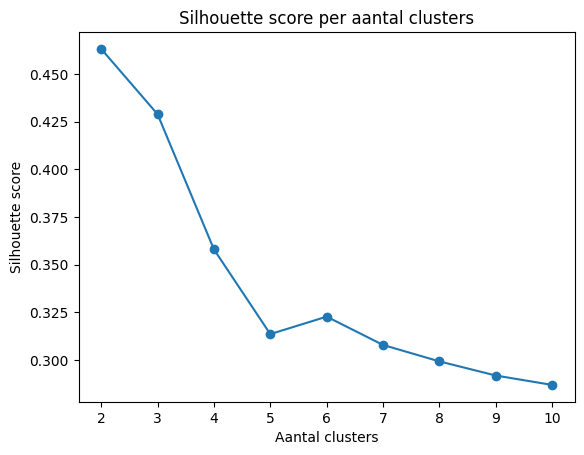

In [ ]:
# Aanmaak dendrogram met juiste settings
dendrogram_vis = linkage(X_unlabeled, method='average', metric='euclidean')

# plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(dendrogram_vis)
plt.title("Dendrogram voor Agglomerative Clustering (average)")
plt.xlabel("Audio samples")
plt.ylabel("Afstand")
plt.show()

# berekenen silhouette score voor elke clusterhoeveelheid (1-10)
scores_dendrogram = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = agg.fit_predict(X_unlabeled)
    score = silhouette_score(X_unlabeled, labels)
    scores_dendrogram.append(score)

plt.plot(range(2,11), scores_dendrogram, marker='o')
plt.xlabel("Aantal clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score per aantal clusters")
plt.show()

### 6.2.4 Toepassing op onze dataset

Uit onze analyse blijkt dat de volgende parameters het best zijn: 
1. Een k van 5, dit zegt tegen het model dat we 5 clusters willen
2. Clustering met de average linkage
3. Afstand berekenen met de euclidean distance

Met deze 3 parameters verwachten we een stabiel model dat effectief genres kan voorspellen en kan opdelen in de juiste clusters voor de onbekende audio samples.

In [ ]:
# initialiseren van het model
best_k = 5

agg = AgglomerativeClustering(n_clusters=best_k, affinity ='euclidean', linkage='average')
agg_labels = agg.fit_predict(X_unlabeled)

df_unlabeled["agglo_cluster"] = agg_labels



### 6.2.5 Koppelen van clusters aan genres

Net als bij KMeans gebruiken we de gelabelde data om per cluster het meest voorkomende genre te bepalen (majority vote). Op basis daarvan kunnen we de unlabeled fragmenten een genre toewijzen.

In [ ]:
# labeled + unlabeled
X_combined = np.vstack([X_labeled, X_unlabeled])

combined_labels = agg.fit_predict(X_combined)

# Split labels terug
df_labeled["agglo_cluster"] = combined_labels[:len(X_labeled)]
df_unlabeled["agglo_cluster"] = combined_labels[len(X_labeled):]

# Cluster → genre mapping
agg_cluster_to_genre = (
    df_labeled
    .groupby("agglo_cluster")["genre"]
    .agg(lambda x: x.value_counts().idxmax()))

df_unlabeled["agglo_genre"] = (
    df_unlabeled["agglo_cluster"]
    .map(agg_cluster_to_genre))

display(df_unlabeled)

,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,filename,cluster,predicted_genre_KMeans,agglo_cluster,agglo_genre
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,-3.283182,m00003.wav,0,classical,2,metal
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,-18.557953,m00012.wav,0,classical,2,metal
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,-12.745122,m00013.wav,3,metal,1,classical
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,-3.806012,m00043.wav,0,classical,2,metal
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,0.777301,m00044.wav,1,country,3,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,-10.287586,m00971.wav,3,metal,1,classical
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,9.721153,m00973.wav,2,pop,0,pop
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,3.778163,m00988.wav,2,pop,0,pop
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,7.907838,m00991.wav,1,country,1,classical


### 6.2.6 Interpretatie

Agglomerative Clustering kan een andere structuur in de data vinden dan KMeans, omdat het niet werkt met vaste clustercentra maar met onderlinge afstanden tussen clusters. Hierdoor kan het soms beter omgaan met ongelijke cluster-groottes.

Door de resultaten te vergelijken met die van KMeans kunnen we bepalen welk model het meest logisch aansluit bij de verdeling van genres in onze dataset.

## 6.3 DBSCAN 

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is een clustering-algoritme dat werkt op basis van dichtheid. In plaats van vooraf een vast aantal clusters te kiezen, kijkt DBSCAN naar gebieden waar veel datapunten dicht bij elkaar liggen. Punten die niet in zo'n dicht gebied liggen, worden beschouwd als ruis (outliers).

Het algoritme gebruikt twee belangrijke parameters:
•	eps (epsilon): de maximale afstand waarbinnen punten als buren worden gezien
•	min_samples: het minimum aantal punten dat binnen die afstand moet liggen om een cluster te vormen

Een belangrijk verschil met KMeans en Agglomerative is dat DBSCAN geen vooraf gekozen aantal clusters nodig heeft. Het aantal clusters ontstaat automatisch op basis van de dichtheid in de data. Het model probeert deze clusters te vormen op een vergelijkbare manier dat een mens dat zou doen (Statquest, 2022). Maar als er meer dan 3 features zijn, zoals bij ons, dan is de oog test niet meer een geschikte toets. Dat is waarom we de juiste instellingen moeten vinden voor epsilon en min_samples om er voor te zorgen dat het model goed presteert.
Hie deze parameters gekozen worden en wat er mis kan gaan als het verkeerd gaat gaan we bespreken in de hoofdstukken hieronder. 





Wanneer genoeg punten binnen de eps-afstand van elkaar liggen, ontstaat een cluster. Punten die niet aan deze voorwaarden voldoen, krijgen label -1 en worden als ruis beschouwd.

Een belangrijk verschil met KMeans en Agglomerative is dat DBSCAN geen vooraf gekozen aantal clusters nodig heeft. Het aantal clusters ontstaat automatisch op basis van de dichtheid in de data.

### 6.3.1 Vinden van de optimale parameters voor DBSCAN: 

**Min_samples:**
Min_samples is een belangrijke instelling die de gebruiker zelf moet instellen, deze instelling bepaald hoeveel andere datapunten er in de buurt moeten zijn voor een punt om een 'Core Point' te worden (Statquest, 2022; Stataiml, 2024). De afstand dat als 'in de buurt' wordt gerekent word bepaald door de Epsilon, wat in het kort een cirkel is rondom het datapunt. In de afbeelding 'Core points (min_samples) van Statquest (2022) kun je zien hoe de core points gekozen worden.
Naast Core points zijn er ook 'non-core points' in de dataset en outliers (Statquest, 2022). 'non-core points' zijn de datapunten die binnen hun Epsilon grenzen aan een core point, maar zelf geen core point zijn omdat ze niet genoeg punten om zich heen hebben. Een klein mogelijk nadeel in het kiezen van de non-core points is dat DBSCAN stapsgewijs de clusters vormt, wanneer non-core points worden toegekent aan bijvoorbeeld cluster 1 is het niet meer mogelijk voor dat punt om toegekent te worden aan cluster 2, ook als deze daar dichterbij zit (Statquest, 2022).
Outliers zijn alle punten die zelf geen core points zijn en ook niet grenzen aan een core point (Statquest, 2022). 

**Hoe bepaal je het optimale aantal voor min_samples?**
De standaard vuistregel is dat je de hoeveelheid dimensies van je data + 1 kiest voor min samples of hoeveelheid dimensies van je data * 2 (Stataiml, 2024; TheDataPost, 2020). De reden hiervoor is dat waardes voor min_samples lager dan het aantal dimensies kan resulteren in te veel kleine clusters. Onze dataset heeft niet veel samples, dit zou ervoor kunnen zorgen dat een optimaal aantal min_samples lager ligt dan wat de vuistregel aanraad, maar voor ons model beginnen we met de aanname dat de hoeveelheid dimensies + 1 het beste is voor ons model. 


**Epsilon:**
De Epsilon is dus de aftand tussen de datapunten die we instellen om te bepalen welke datapunten bij een cluster horen / (non) core points of ruis zijn. Als de Epsilon te klein is dan kan dit resulteren in veel ruis, dan worden er weinig core points aangemaakt en dan zullen er veel punten die wel in het cluster horen niet toegekent worden. Als de Epsilon te groot is dan worden te veel punten een core point, dit kan leiden tot veel outliers die worden toegekent aan een groep en het samenvoegen van 2 verschillende genres in 1 cluster. 

** Hoe bepaal je het optimale aantal voor Epsilon:** 
Voor het kiezen van de optimale Epsilon moeten we de K-distance berekenen en daarna kunnen we met de elleboog methode inzichten krijgen in welke mogelijke epsilons het best zijn (Stataiml, 2024; TheDataPost, 2020). 


De eerste stap hierin is het aantal min_samples bepalen, wij hebben hier gekozen voor shape + 1. Dit lijkt ons de beste keuze aangezien het probeert ruis te vermijden en het vormen van onnodig grote groepen (Statquest, 2022). 
Nu plotten we de afstand van de 12ste neighbour voor elk datapunt op oplopende wijze. Hieruit zoeken we naar een punt die knik, echter is er in onze plot geen duidelijk punt waar dit gebeurt. Om erachter te komen welke epsilon het meest geschrikt is moeten dus over een range van waardes loopen om erachter te komen welken het best past (TheDataPost, 2020). 

We hebben voor elke epsilon van 1.5 tot 3 in stappen van 0.1 een DBSCAN model getraint en de resultaten gevisualiseerd in verschillende plot (met PCA) (OpenAI. (2026). ChatGPT (GPT-5.2). Prompt 1 & 2: DBSCAN optimal epsilon zoeken).

Bij epsilon waardes tussen 2.2 en 2.8 vertonen de meeste groepen (3) en alle waardes daarbuiten vertonen maar 2 groepen of minder. Epsilon van 2.2 tot 2.8 zijn de enige realistische waardes aangezien er anders duidelijk zichtbaar is dat een cluster die hoort te bestaan gezien wordt als ruis, of de hele dataset is 1 cluster. 
De epsilon van 2.8 lijkt het beste te passen op de data, echter lijkt ons de beste waarde voor epsilon **2.7**. Dit komt omdat 2.9 een zeer slecht gefit model is die maar 1 cluster voorspelt, als we de epsilon van 2.8 kiezen is de kans groot dat het DBSCAN model op andere onbekende data ook maar 1 cluster zou voorspellen. 
Om dit te verkomen maar toch de beste prestaties te hebben kiezen wij daarom van een epislon waarde van 2.7



Bron core points (min_samples) (Statquest, 2022)
https://www.youtube.com/watch?v=RDZUdRSDOok

<img src="image-20260214-150812.png" width="" align="" />

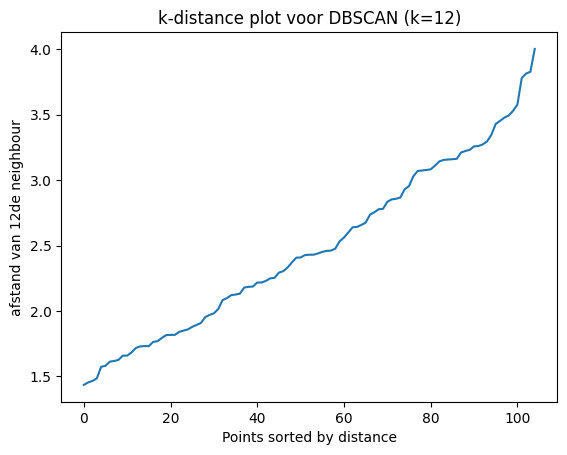

In [ ]:
# code van (Stataiml, 2024)
from sklearn.neighbors import NearestNeighbors

# min_samples gebaseerd op aantal features + 1 (compenseer voor k_neighbours waar datapunten zichzelf meerekenen) 
min_samples = X_unlabeled.shape[1] + 1  

# Compute k-nearest neighbors
# voeg 1 toe omdat NearestNeighbors zichzelf als eerste buur meeneemt
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_unlabeled)

# get distances
dist, ind = nbrs.kneighbors(X_unlabeled)
k_dist = np.sort(dist[:, -1])

# plot de k-distance
plt.plot(k_dist)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'afstand van 12de neighbour')
plt.title(f'k-distance plot voor DBSCAN (k=12)')
plt.show()




[OpenAI. (2026). ChatGPT (GPT-5.2). Prompt 1 & 2: DBSCAN optimal epsilon zoeken](https://chatgpt.com/share/699218c2-7db0-8012-a343-51e503372184)


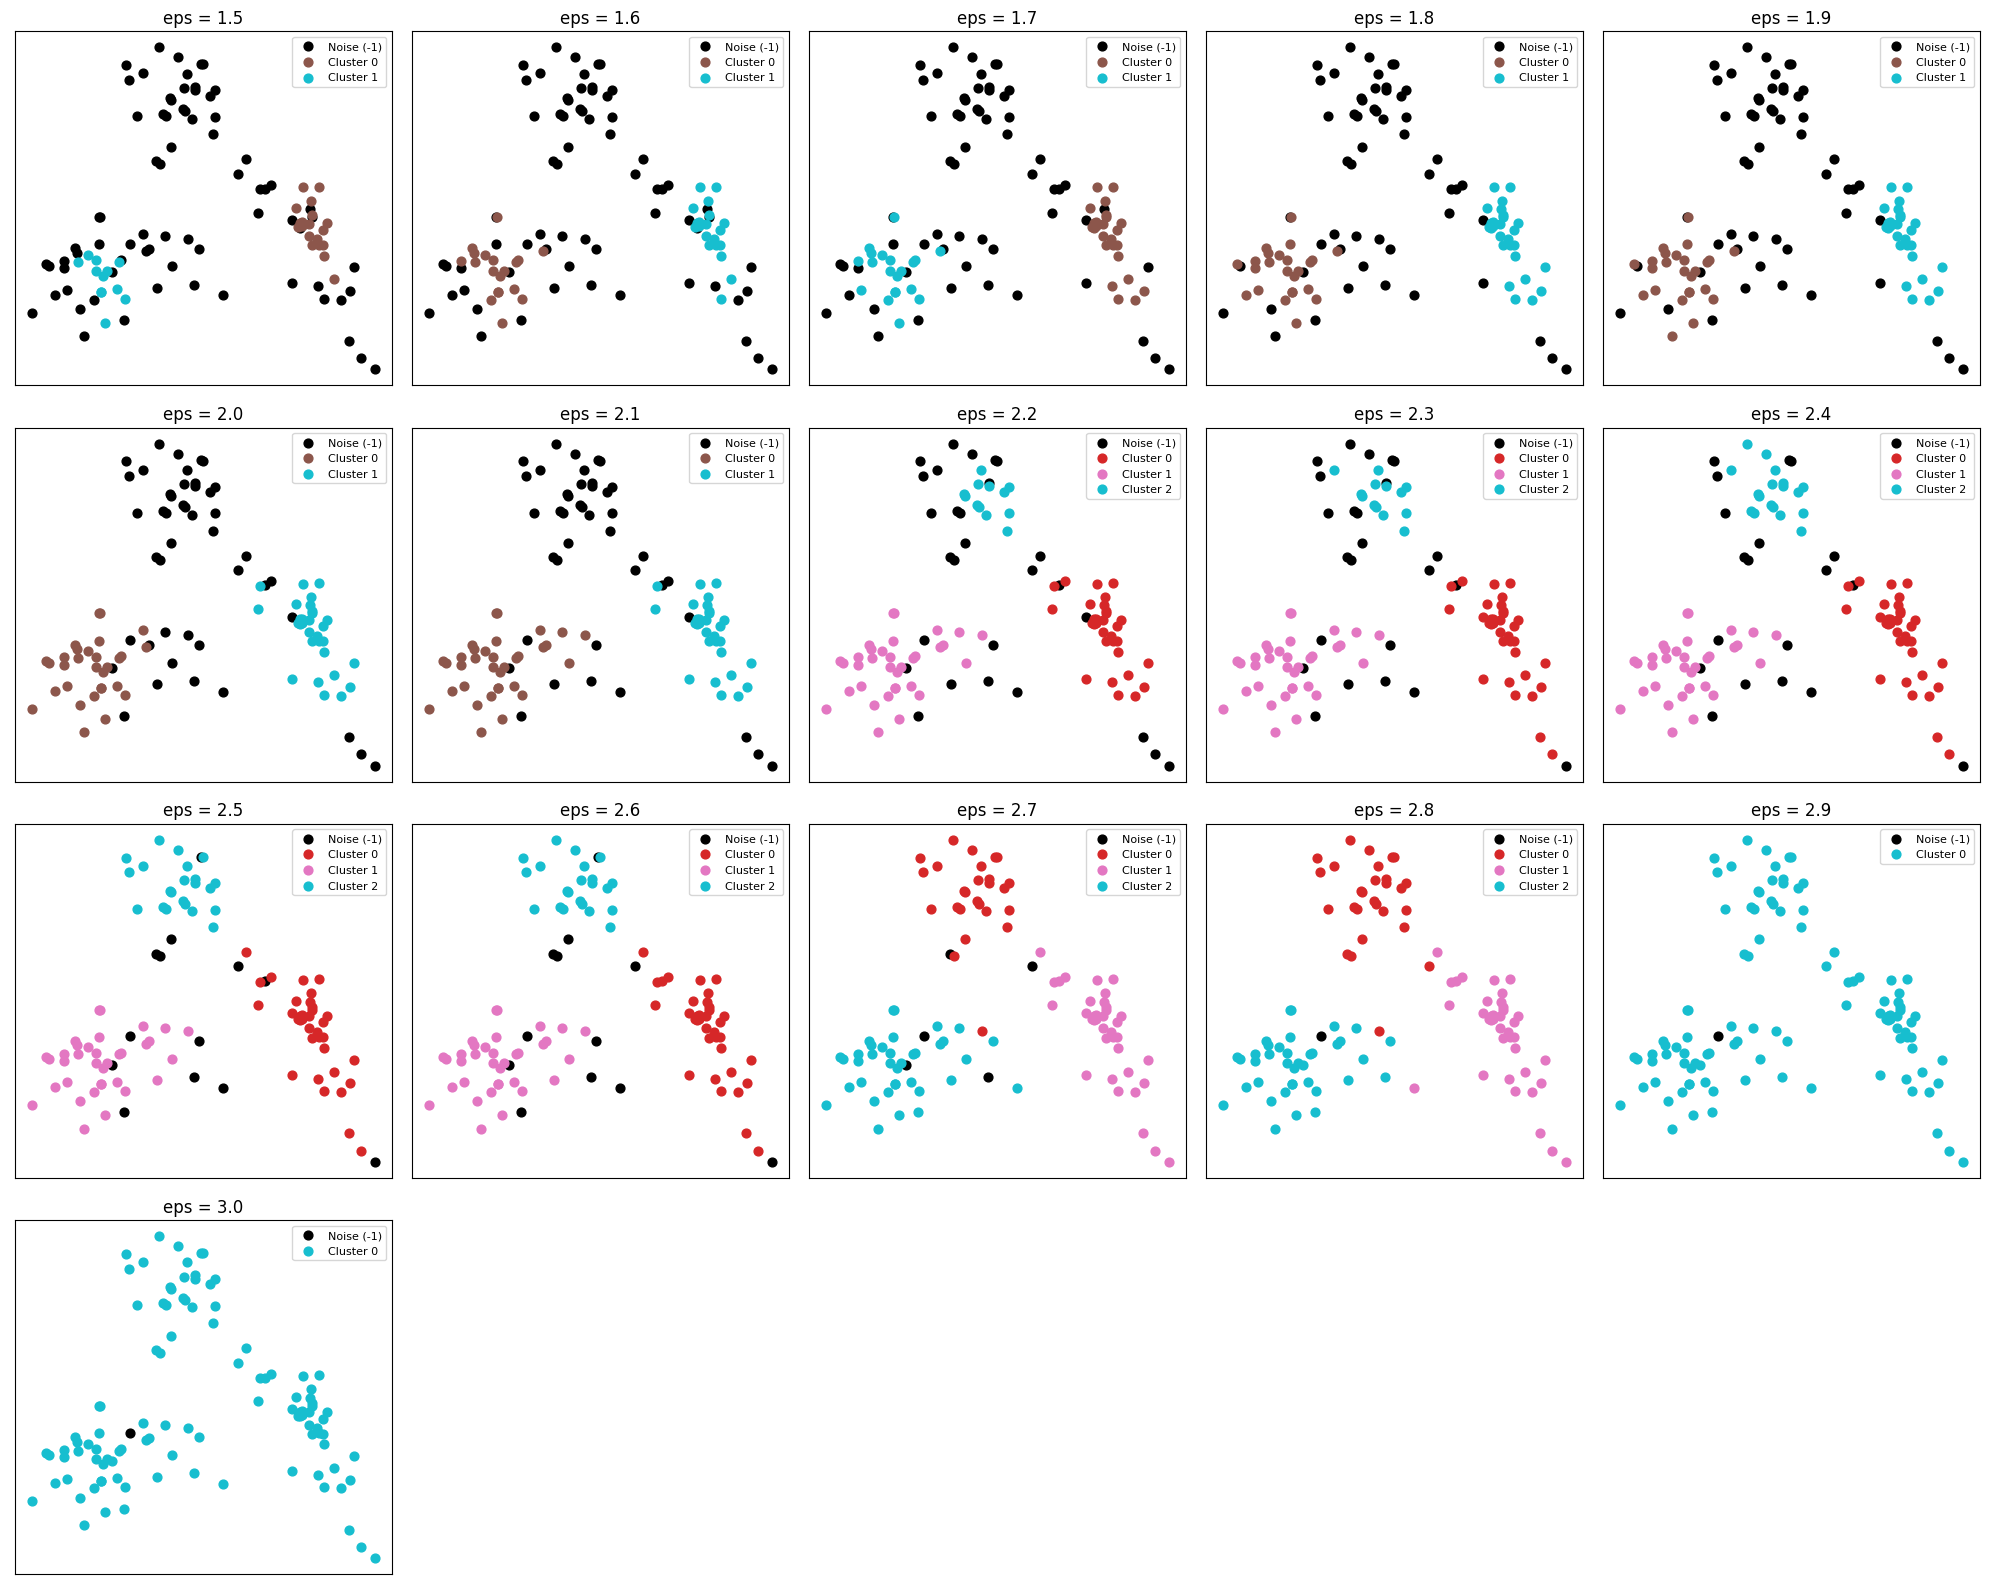

In [ ]:
# Gebruikte prompt: ChatGPT (GPT-5.2). Prompt 1 & 2: DBSCAN optimal epsilon zoeken

#range van eps values waarover we willen lopen en traditionele min_samples
min_samples = X_unlabeled.shape[1] + 1
eps_values = np.arange(1.5, 3.1, 0.1)

# PCA voor visualisatie
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unlabeled)

#instellingen voor de plots
n_plots = len(eps_values)
cols = 5
rows = int(np.ceil(n_plots / cols))

plt.figure(figsize=(20, 4 * rows))

for i, eps in enumerate(eps_values):
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_unlabeled)
    
    plt.subplot(rows, cols, i + 1)
    
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        
        if label == -1:
            plt.scatter(
                X_pca[mask, 0],
                X_pca[mask, 1],
                color="black",
                s=40,
                label="Noise (-1)"
            )
        else:
            plt.scatter(
                X_pca[mask, 0],
                X_pca[mask, 1],
                color=color,
                s=40,
                label=f"Cluster {label}")
    
    plt.title(f"eps = {eps:.1f}")
    plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


### 6.3.2 Toepassing op onze dataset

Omdat DBSCAN gevoelig is voor schaalverschillen, is het belangrijk dat de features goed geschaald zijn voordat het model wordt toegepast. In hoofdstuk 4 hebben wij een standardscaler toegepast om dit te bereiken.



In [ ]:
# parameters
min_samples = X_unlabeled.shape[1] + 1
epsilon = 2.7

dbscan = DBSCAN(eps= epsilon, min_samples= min_samples)
db_labels = dbscan.fit_predict(X_unlabeled)

df_unlabeled["dbscan_cluster"] = db_labels

### 6.3.3 Interpretatie van de resultaten

Bij DBSCAN kan het voorkomen dat sommige punten label -1 krijgen. Dit betekent dat deze fragmenten niet dicht genoeg bij andere punten liggen om tot een cluster te behoren. In de context van muziek kan dit betekenen dat bepaalde fragmenten sterk afwijken van de rest, dit valt ook te verwachten aangezien genres een subjectief label geven aan muziek.

Het aantal gevonden clusters hangt sterk af van de gekozen waarden voor eps en min_samples. Als eps te klein is, ontstaan veel kleine clusters of veel ruis. Als eps te groot is, worden clusters samengevoegd.

Daarom is DBSCAN vooral geschikt wanneer:
•	Het aantal clusters onbekend is
•	Er mogelijk outliers aanwezig zijn
•	Clusters geen duidelijke ronde vorm hebben

### 6.3.4 Rol binnen ons onderzoek
In deze opdracht gebruiken wij DBSCAN als vergelijking met KMeans en Agglomerative Clustering. 
Vanuit onze analyse blijkt dat voor beide modellen het optimale aantal clusters 5 is, de manier waarop dit bepaald wordt is zeker niet vrij van subjectiviteit, maar het geeft wel een goed beeld van wat waarschijnlijk het geval is. 
DBSCAN stelt niet precies in hoeveel clusters er ontstaan, maar de gekozen parameters beinvloeden wel hoe de clusters eruit komen te zien. We verwachten dit DBSCAN minder stabiel werkt vanwege deze eigenschap. 



### 6.3.5 koppelen aan genres (dbscan)
Tijdens het samenvoegen van de labeled en unlabeled datasets zodat we de clusters de juiste namen kunnen geven gaat er iets fout met het model. Na testen lijkt dat alleen Metal gekozen word met de voorheen bepaalde instellingen en dat bij een epsilon van 1.5 en min_samples van 5 er wel meerdere genres worden gemaakt. Het lijkt dat de extra data van de labeled dataset ervoor zorgt dat de instellingen van voorheen een te wijde epsilon geven en ook dat andere genres naast metal moeten hebben om core points te worden voor hun genre. Dit zou kunnen komen doordat Metal mogelijk de eerst voorkomende genre is in df_unlabeld, en met de huidige instellingen wordt elk punt erkent als Metal, voordat de andere genres een kans krijgen om aan de beurt te komen. 

In [ ]:
X_combined = np.vstack([X_labeled, X_unlabeled])


dbscan_real = DBSCAN(eps=epsilon, min_samples=min_samples)
combined_labels_real = dbscan_real.fit_predict(X_combined)

df_labeled["dbscan_cluster_real"] = combined_labels_real[:len(X_labeled)]
df_unlabeled["dbscan_cluster_real"] = combined_labels_real[len(X_labeled):]

dbscan_cluster_to_genre_real = (
    df_labeled
    .groupby("dbscan_cluster_real")["genre"]
    .agg(lambda x: x.value_counts().idxmax())
)

df_unlabeled["dbscan_genre_real"] = (
    df_unlabeled["dbscan_cluster_real"]
    .map(dbscan_cluster_to_genre_real)
)

**Om toch het model te gebruiken in vergelijkingen en omdat we het ook willen uploaden in kaggle is hier een model met gekozen parameters die ervoor zorgen dat er meerdere genres gemapt worden.**

In [ ]:
X_combined = np.vstack([X_labeled, X_unlabeled])

dbscan_verzonnen = DBSCAN(eps=1.5, min_samples=5)
combined_labels_verzonnen = dbscan_verzonnen.fit_predict(X_combined)

df_labeled["dbscan_cluster_verzonnen"] = combined_labels_verzonnen[:len(X_labeled)]
df_unlabeled["dbscan_cluster_verzonnen"] = combined_labels_verzonnen[len(X_labeled):]

dbscan_cluster_to_genre_verzonnen = (
    df_labeled
    .groupby("dbscan_cluster_verzonnen")["genre"]
    .agg(lambda x: x.value_counts().idxmax())
)

df_unlabeled["dbscan_genre_verzonnen_parameters"] = (
    df_unlabeled["dbscan_cluster_verzonnen"]
    .map(dbscan_cluster_to_genre_verzonnen)
)

display(df_unlabeled)

,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,filename,cluster,predicted_genre_KMeans,agglo_cluster,agglo_genre,dbscan_cluster,dbscan_cluster_real,dbscan_genre_real,dbscan_cluster_verzonnen,dbscan_genre_verzonnen_parameters
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,...,m00003.wav,0,classical,2,metal,0,0,metal,-1,country
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,...,m00012.wav,0,classical,2,metal,0,0,metal,-1,country
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,...,m00013.wav,3,metal,1,classical,1,0,metal,-1,country
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,...,m00043.wav,0,classical,2,metal,0,0,metal,-1,country
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,...,m00044.wav,1,country,3,blues,1,0,metal,-1,country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,...,m00971.wav,3,metal,1,classical,1,0,metal,2,classical
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,...,m00973.wav,2,pop,0,pop,2,0,metal,1,reggae
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,...,m00988.wav,2,pop,0,pop,2,0,metal,-1,country
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,...,m00991.wav,1,country,1,classical,1,0,metal,2,classical


## 6.4 Vergelijken van algoritmes

In dit onderdeel vergelijken we de prestaties van KMeans, Agglomerative Clustering en DBSCAN. Het doel is om te bepalen welk model het meest geschikt is voor het groeperen van muziekfragmenten op basis van hun audiofeatures.

We vergelijken de modellen op basis van:
•	Het aantal gevonden clusters
•	De silhouette score
•	De interpretatie van de resultaten

### 6.4.1 Silhouette score per model

In [ ]:
results = []

# KMeans
kmeans = KMeans(n_clusters=5, n_init=10)
labels_kmeans = kmeans.fit_predict(X_unlabeled)
sil_kmeans = silhouette_score(X_unlabeled, labels_kmeans)

results.append({
    "Model": "KMeans",
    "Aantal clusters": len(np.unique(labels_kmeans)),
    "Silhouette score": sil_kmeans})

# Agglomerative
agg = AgglomerativeClustering(n_clusters=best_k, affinity ='euclidean', linkage='average')
labels_agg = agg.fit_predict(X_unlabeled)
sil_agg = silhouette_score(X_unlabeled, labels_agg)

results.append({
    "Model": "Agglomerative",
    "Aantal clusters": len(np.unique(labels_agg)),
    "Silhouette score": sil_agg})

# DBSCAN
dbscan = DBSCAN(eps= epsilon, min_samples= min_samples)
labels_db = dbscan.fit_predict(X_unlabeled)

# mask voor niet-ruispunten, anders is silhouette score NaN
mask = labels_db != -1

# Check of er meer dan 1 cluster is (anders kan silhouette niet berekend worden) en voegt de resultaten toe aan results
if len(np.unique(labels_db[mask])) > 1:
    sil_db = silhouette_score(X_unlabeled[mask], labels_db[mask])
else:
    sil_db = None
results.append({
    "Model": "DBSCAN",
    "Aantal clusters": len(set(labels_db[mask])),
    "Silhouette score": sil_db})

labels_db = dbscan.fit_predict(X_unlabeled)




comparison_df = pd.DataFrame(results)
comparison_df

,Model,Aantal clusters,Silhouette score
0,KMeans,5,0.282633
1,Agglomerative,5,0.313497
2,DBSCAN,3,0.455001


### 6.4.2 Interpretatie van de vergelijking

KMeans en Agglomerative Clustering werken met een vooraf gekozen aantal clusters (in ons geval k = 5). DBSCAN bepaalt zelf het aantal clusters op basis van dichtheid, voor deze data zijn dat 3 clusters.

Wanneer we de silhouette scores vergelijken, kijken we naar welke methode de beste balans vindt tussen:
•	Compacte clusters
•	Duidelijke scheiding tussen clusters

Een hogere silhouette score betekent dat de clusters beter van elkaar te onderscheiden zijn.

Daarnaast kijken we ook naar het aantal clusters dat DBSCAN daadwerkelijk vindt. Als dit sterk afwijkt van de andere modellen, kan dit betekenen dat DBSCAN minder goed aansluit bij de structuur van onze dataset.


### 6.4.3 Definitieve keuze van het clustering model

De vergelijking laat zien dat DBSCAN de hoogste silhouette score heeft met een score van 0.45. Agglomerative clustering heeft een silhouette score van 0.31 en KMEans een score van 0.26. Het is logisch dat DBSCAN de hoogste silhouette score heeft aangezien DBSCAN tussen minder clusters voorspelt, dit maakt het makkelijker om een zuivere en duidelijke splitsing te hebben. 

DBSCAN heeft een hoge score, maar het kan maar 3 clusters vinden terwijl de andere 2 modellen sterk suggereren dat er 5 verschillende genres aanwezig zijn in de data. Het model heeft waarschijnlijk moeite met het onderscheiden van deze genres aangezien veel kenmerken/features van een nummer voor verschillende genres overeenkomen. 

DBSCAN lijkt on daarom niet het geschikte model voor het vinden van alle aanwezige genres in df_unlabeled. Overigens hebben we het model op dit moment ook niet goed kunnen koppelen aan de genres aangezien het model heel anders presteert wanneer we x_labeled en X_Unlabeled samenvoegen.

Tussen K-Means en Agglomerative clustering lijkt **agglomerative clustering ons beste model**. Het heeft dezelfde hoeveelheid clusters als K-Means en het heeft een hogere silhouette score. 

Daarbovenop kan Agglomerative clustering beter omgaan met data die minder bol vormig is, dit komt omdat Agglomerative Clustering voor elk datapunt kijkt naar hoe dicht het zit bij een core-point, en niet naar de centroid zoals bij K-Means. Dit betekent dat niet alleen kijkt naar de spreiding van de centroid, maar dat het ook de spreiding van verdere punten kan herkennen als een duidelijke indicator dat het behoort tot hetzelfde genre. Dit is nuttig voor het voorspellen van muziek genre aangezien veel features qua afstand mogelijk niet heel ver van elkaar vandaan zitten, maar tussen die kleine afstand zit toch een groot verschil in density tussen de 2 genres.



# 7 Dimensional reduction

## 7.1 Principal Component Analysis (PCA)

PCA is een manier om grote hoeveelheden data simpeler te maken. Als je veel data hebt met veel variabelen is het vaak lastig om met het model te werken. Het is dan vaak heel erg moeilijk om patronen in de data te herkennen. PCA is dus een manier om grote hoeveelheden data te verkleinen, zonder dat er belangrijke informatie verloren gaat. 

Normaal gesproken gebruik je de oorspronkelijke variabelen binnen een dataset om de patronen te herkennen, alleen bij PCA gaat het anders, PCA maakt namelijk nieiwe variabelen aan door alle oorspronkelijke variabelen te combineren. 

De belangrijkste PCs zijn
- PC1: Bepaalt de richting waarin de data opgaat
- PC2: Bepaalt de 2e grootste variatie

PCA werkt goed bij unsupervised learning omdat er bij PCA niet gekeken wordt naar de labels, het kijkt alleen naar de structuur in de data zelf.Het zorgt er ook voor dat er minder ruis in de data komt en het model beter presteert en sneller gerunt kan worden.

Er zijn ook 2 nadelen voor PCA:
- Nieuwe componenten zijn moeilijk te interpreteren omdat het een combinatie gebruikt van alle variabelen.
- Doordat er minder variabelen gebruikt worden blijft de belangrijkste informatie behouden, alleen gaat er altijd wel wat informatie verloren.

https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-pca/
https://www.youtube.com/watch?v=FgakZw6K1QQ&t=6s
https://builtin.com/data-science/step-step-explanation-principal-component-analysis

PC1 verklaart 67.66% van de variantie
PC2 verklaart 14.45% van de variantie
Totaal verklaard: 82.11%


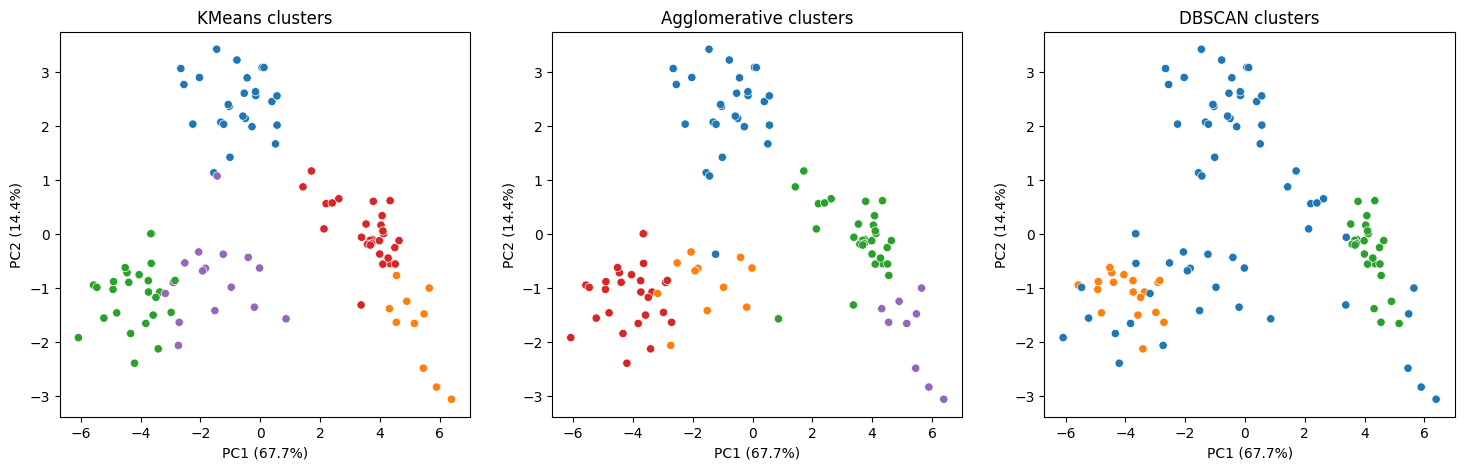

In [ ]:
# PCA uitvoeren op unlabeled features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unlabeled)

explained_var = pca.explained_variance_ratio_
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

print(f"PC1 verklaart {pc1_var:.2f}% van de variantie")
print(f"PC2 verklaart {pc2_var:.2f}% van de variantie")
print(f"Totaal verklaard: {(pc1_var + pc2_var):.2f}%")

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_unlabeled)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(X_unlabeled)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_unlabeled)

# Plot
plt.figure(figsize=(18,5))


plt.subplot(1,3,1)
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=kmeans_labels,
    palette="tab10",
    legend=False)
plt.xlabel(f"PC1 ({pc1_var:.1f}%)")
plt.ylabel(f"PC2 ({pc2_var:.1f}%)")
plt.title("KMeans clusters")

plt.subplot(1,3,2)
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=agg_labels,
    palette="tab10",
    legend=False)
plt.xlabel(f"PC1 ({pc1_var:.1f}%)")
plt.ylabel(f"PC2 ({pc2_var:.1f}%)")
plt.title("Agglomerative clusters")

plt.subplot(1,3,3)
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=dbscan_labels,
    palette="tab10",
    legend=False)
plt.xlabel(f"PC1 ({pc1_var:.1f}%)")
plt.ylabel(f"PC2 ({pc2_var:.1f}%)")
plt.title("DBSCAN clusters")

plt.show()


## 7.2 Non-Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization (NMF) is een techniek voor dimensionality reduction waarbij een dataset wordt ontbonden in een beperkt aantal onderliggende componenten. Het uitgangspunt is dat elke observatie kan worden weergegeven als een optelsom van positieve bouwstenen.

In tegenstelling tot PCA, dat nieuwe assen zoekt die maximale variantie verklaren, probeert NMF de oorspronkelijke data te reconstrueren met een kleiner aantal interpreteerbare componenten. Het model zoekt dus naar verborgen structuren in de data die samen de oorspronkelijke featurematrix zo goed mogelijk benaderen.

Het idee is dat een muziekfragment niet één enkele eigenschap heeft, maar bestaat uit een combinatie van onderliggende patronen, bijvoorbeeld energieprofielen, frequentieverdelingen of klankstructuren.


De wiskundige vorm van NMF is:

**V ≈ W · H**

waarbij:
•	V de oorspronkelijke featurematrix is (aantal fragmenten × aantal features)
•	W een matrix is per fragment de gewichten van de componenten
•	H een matrix is met de onderliggende componenten

Belangrijk is dat alle waarden in V, W en H niet-negatief zijn.

Dit betekent dat elk fragment wordt weergegeven als een optelsom van positieve componenten. Er worden dus geen negatieve combinaties gebruikt, zoals bij PCA. Hierdoor ontstaat een additief model: elk muziekfragment wordt opgebouwd uit basispatronen met een bepaalde sterkte.


**Toepassing op onze muziekdata**
In onze dataset bevat V per muziekfragment kenmerken zoals spectral centroid, RMS, tempo en MFCC's. Door NMF toe te passen proberen we te achterhalen of deze features kunnen worden samengevat in een kleiner aantal onderliggende muzikale patronen.

Elke component in H kan worden gezien als een soort basisprofiel van audio-eigenschappen. De matrix W geeft vervolgens aan hoe sterk elk fragment overeenkomt met die profielen.

Om het aantal componenten te bepalen analyseren we de **reconstructiefout**. Deze fout meet hoe goed W · H de oorspronkelijke matrix V benadert. Naarmate het aantal componenten stijgt, daalt de fout. We zoeken naar een punt waar de daling afvlakt, omdat extra componenten dan relatief weinig extra informatie toevoegen. In onze analyse stabiliseert dit rond negen componenten.

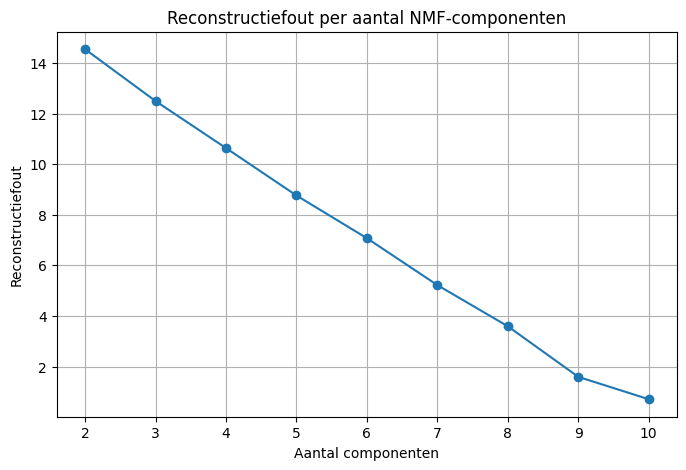

In [ ]:
components_range = range(2, 11)
reconstruction_errors = []

# niet-negatieve input
X_nonneg = np.abs(X_unlabeled)

for n in components_range:
    nmf = NMF(n_components=n, random_state=42, max_iter=1000)
    W = nmf.fit_transform(X_nonneg)
    reconstruction_errors.append(nmf.reconstruction_err_)

plt.figure(figsize=(8,5))
plt.plot(components_range, reconstruction_errors, marker="o")
plt.xlabel("Aantal componenten")
plt.ylabel("Reconstructiefout")
plt.title("Reconstructiefout per aantal NMF-componenten")
plt.grid(True)
plt.show()

In [ ]:
nmf = NMF(n_components=9, random_state=42, max_iter=1000)
W = nmf.fit_transform(X_nonneg)
H = nmf.components_

print("Shape W (fragment x component):", W.shape)
print("Shape H (component x feature):", H.shape)

Shape W (fragment x component): (105, 9)
Shape H (component x feature): (9, 11)


In [ ]:
X_nmf = nmf.fit_transform(X_nonneg)
kmeans_nmf = KMeans(n_clusters=5, random_state=42)
labels_nmf = kmeans_nmf.fit_predict(X_nmf)

sil_nmf = silhouette_score(X_nmf, labels_nmf)

print("Silhouette score (NMF + KMeans):", sil_nmf)

Silhouette score (NMF + KMeans): 0.22809311739285157


### 7.2.1 Interpretatie 
Na het reduceren van de dimensies met NMF (9 componenten) en het toepassen van KMeans met k = 5, werd een silhouette score van 0.228 behaald. Dit ligt lager dan de score op de oorspronkelijke feature-ruimte (≈ 0.28).

Dit betekent dat de clusters in de NMF-ruimte minder duidelijk van elkaar gescheiden zijn. Hoewel NMF de data kan beschrijven als een combinatie van positieve basispatronen, blijkt deze representatie minder geschikt voor afstandsgebaseerde clustering dan PCA of de oorspronkelijke geschaalde features.

Daarom concluderen wij dat NMF in deze opdracht vooral waardevol is als alternatieve manier om de structuur van de muziekdata te analyseren, maar niet als verbetering van de clusterkwaliteit.

https://medium.com/@quindaly/step-by-step-nmf-example-in-python-9974e38dc9f9

# Kaggle submissions


### clustering van PCA modellen 


In [ ]:
# PCA voor labeled en unlabeled df
pca = PCA(n_components=2)
X_unlabeled_pca = pca.fit_transform(X_unlabeled)
X_labeled_pca = pca.transform(X_labeled)


In [ ]:
# KMeans PCA
kmeans_pca = KMeans(n_clusters=5, random_state=42, n_init=10)

# unlabeled
df_unlabeled["cluster_pca_kmeans"] = kmeans_pca.fit_predict(X_unlabeled_pca)
display(df_unlabeled)

# labeled
kmeans_pca_labeled = KMeans(n_clusters=5, random_state=42)
df_labeled["cluster_pca_kmeans"] = kmeans_pca_labeled.fit_predict(X_labeled_pca)

# Bepaal per cluster het meest voorkomende genre
cluster_to_genre_pca = (
    df_labeled
    .groupby("cluster_pca_kmeans")["genre"]
    .agg(lambda x: x.value_counts().idxmax())
)

print("Cluster → genre mapping (PCA KMeans):")
print(cluster_to_genre_pca)

# Map de clusters naar genres in unlabeled data
df_unlabeled["predicted_genre_pca_KMeans"] = df_unlabeled["cluster_pca_kmeans"].map(cluster_to_genre_pca)

display(df_unlabeled)


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,cluster,predicted_genre_KMeans,agglo_cluster,agglo_genre,dbscan_cluster,dbscan_cluster_real,dbscan_genre_real,dbscan_cluster_verzonnen,dbscan_genre_verzonnen_parameters,cluster_pca_kmeans
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,...,0,classical,2,metal,0,0,metal,-1,country,0
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,...,0,classical,2,metal,0,0,metal,-1,country,0
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,...,3,metal,1,classical,1,0,metal,-1,country,4
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,...,0,classical,2,metal,0,0,metal,-1,country,0
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,...,1,country,3,blues,1,0,metal,-1,country,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,...,3,metal,1,classical,1,0,metal,2,classical,4
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,...,2,pop,0,pop,2,0,metal,1,reggae,2
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,...,2,pop,0,pop,2,0,metal,-1,country,2
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,...,1,country,1,classical,1,0,metal,2,classical,1


Cluster → genre mapping (PCA KMeans):
cluster_pca_kmeans
0        metal
1    classical
2          pop
3        disco
4       reggae
Name: genre, dtype: object


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,predicted_genre_KMeans,agglo_cluster,agglo_genre,dbscan_cluster,dbscan_cluster_real,dbscan_genre_real,dbscan_cluster_verzonnen,dbscan_genre_verzonnen_parameters,cluster_pca_kmeans,predicted_genre_pca_KMeans
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,...,classical,2,metal,0,0,metal,-1,country,0,metal
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,...,classical,2,metal,0,0,metal,-1,country,0,metal
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,...,metal,1,classical,1,0,metal,-1,country,4,reggae
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,...,classical,2,metal,0,0,metal,-1,country,0,metal
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,...,country,3,blues,1,0,metal,-1,country,1,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,...,metal,1,classical,1,0,metal,2,classical,4,reggae
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,...,pop,0,pop,2,0,metal,1,reggae,2,pop
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,...,pop,0,pop,2,0,metal,-1,country,2,pop
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,...,country,1,classical,1,0,metal,2,classical,1,classical


In [ ]:
# Agglomerative clustering PCA
best_k = 5

agg_pca = AgglomerativeClustering(n_clusters=best_k, affinity ='euclidean', linkage='average')

# unlabeled
df_unlabeled["agglo_cluster_PCA"] = agg_pca.fit_predict(X_unlabeled_pca)
display(df_unlabeled)

# labeled
agg_pca_labeled = AgglomerativeClustering(n_clusters=5)
df_labeled["agglo_cluster_PCA"] = agg_pca_labeled.fit_predict(X_labeled_pca)

# Bepaal per cluster het meest voorkomende genre
agglo_cluster_to_genre_pca = (
    df_labeled
    .groupby("agglo_cluster_PCA")["genre"]
    .agg(lambda x: x.value_counts().idxmax())
)

print("Cluster → genre mapping (PCA Agglomerative):")
print(agglo_cluster_to_genre_pca)

# Map de clusters naar genres in unlabeled data
df_unlabeled["predicted_genre_PCA_Agglomerative"] = df_unlabeled["agglo_cluster_PCA"].map(agglo_cluster_to_genre_pca)

display(df_unlabeled)


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,agglo_cluster,agglo_genre,dbscan_cluster,dbscan_cluster_real,dbscan_genre_real,dbscan_cluster_verzonnen,dbscan_genre_verzonnen_parameters,cluster_pca_kmeans,predicted_genre_pca_KMeans,agglo_cluster_PCA
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,...,2,metal,0,0,metal,-1,country,0,metal,2
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,...,2,metal,0,0,metal,-1,country,0,metal,2
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,...,1,classical,1,0,metal,-1,country,4,reggae,0
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,...,2,metal,0,0,metal,-1,country,0,metal,2
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,...,3,blues,1,0,metal,-1,country,1,classical,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,...,1,classical,1,0,metal,2,classical,4,reggae,0
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,...,0,pop,2,0,metal,1,reggae,2,pop,1
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,...,0,pop,2,0,metal,-1,country,2,pop,1
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,...,1,classical,1,0,metal,2,classical,1,classical,0


Cluster → genre mapping (PCA Agglomerative):
agglo_cluster_PCA
0         jazz
1          pop
2        metal
3    classical
4        disco
Name: genre, dtype: object


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,agglo_genre,dbscan_cluster,dbscan_cluster_real,dbscan_genre_real,dbscan_cluster_verzonnen,dbscan_genre_verzonnen_parameters,cluster_pca_kmeans,predicted_genre_pca_KMeans,agglo_cluster_PCA,predicted_genre_PCA_Agglomerative
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,...,metal,0,0,metal,-1,country,0,metal,2,metal
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,...,metal,0,0,metal,-1,country,0,metal,2,metal
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,...,classical,1,0,metal,-1,country,4,reggae,0,jazz
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,...,metal,0,0,metal,-1,country,0,metal,2,metal
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,...,blues,1,0,metal,-1,country,1,classical,4,disco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,...,classical,1,0,metal,2,classical,4,reggae,0,jazz
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,...,pop,2,0,metal,1,reggae,2,pop,1,pop
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,...,pop,2,0,metal,-1,country,2,pop,1,pop
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,...,classical,1,0,metal,2,classical,1,classical,0,jazz


In [ ]:
X_combined_pca = np.vstack([X_labeled_pca, X_unlabeled_pca])

min_samples = 5
epsilon = 1.5

# DBSCAN clustering PCA
dbscan_pca = DBSCAN(eps=epsilon, min_samples=min_samples)
combined_labels_dbscan = dbscan_pca.fit_predict(X_combined_pca)

# Split labels terug
df_labeled["dbscan_cluster_PCA"] = combined_labels_dbscan[:len(X_labeled)]
df_unlabeled["dbscan_cluster_PCA"] = combined_labels_dbscan[len(X_labeled):]

# Cluster → genre mapping op basis van labeled data
dbscan_cluster_to_genre_pca = (
    df_labeled
    .groupby("dbscan_cluster_PCA")["genre"]
    .agg(lambda x: x.value_counts().idxmax())
)

# Map clusters naar genres in unlabeled data
df_unlabeled["predicted_genre_PCA_DBSCAN"] = (
    df_unlabeled["dbscan_cluster_PCA"]
    .map(dbscan_cluster_to_genre_pca)
)

display(df_unlabeled)


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,dbscan_cluster_real,dbscan_genre_real,dbscan_cluster_verzonnen,dbscan_genre_verzonnen_parameters,cluster_pca_kmeans,predicted_genre_pca_KMeans,agglo_cluster_PCA,predicted_genre_PCA_Agglomerative,dbscan_cluster_PCA,predicted_genre_PCA_DBSCAN
0,2254.451748,2070.908729,4381.173508,0.120159,0.136249,135.999178,-82.501259,97.344116,-34.373585,71.405922,...,0,metal,-1,country,0,metal,2,metal,0,metal
1,2908.260266,2286.246872,5405.642313,0.178119,0.217447,103.359375,-1.925410,72.695557,-32.789642,63.592033,...,0,metal,-1,country,0,metal,2,metal,0,metal
2,1953.012399,1865.851544,3780.543806,0.123492,0.029100,95.703125,-287.520996,101.737930,-35.368999,41.282764,...,0,metal,-1,country,4,reggae,0,jazz,0,metal
3,2384.812610,2073.302486,4585.038942,0.126103,0.100442,135.999178,-120.127808,91.287666,-38.794960,75.003784,...,0,metal,-1,country,0,metal,2,metal,0,metal
4,790.478225,899.979779,1159.401323,0.052112,0.018844,107.666016,-437.525238,170.971405,7.386170,-3.108706,...,0,metal,-1,country,1,classical,4,disco,0,metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1525.601267,1588.161024,2732.875141,0.091588,0.038878,107.666016,-246.218369,149.443878,-41.973816,11.606413,...,0,metal,2,classical,4,reggae,0,jazz,0,metal
101,3671.260488,3295.553789,7879.044023,0.161897,0.259807,129.199219,-8.531341,54.251755,20.963310,13.099079,...,0,metal,1,reggae,2,pop,1,pop,0,metal
102,3940.349921,3361.504206,8259.450056,0.167399,0.240877,103.359375,-56.091187,36.468166,11.945320,-6.441751,...,0,metal,-1,country,2,pop,1,pop,0,metal
103,983.761841,1404.132189,1852.522131,0.044227,0.017124,117.453835,-406.965424,163.139465,-2.413815,32.456657,...,0,metal,2,classical,1,classical,0,jazz,0,metal


## Kaggle submissions resultaten


In [ ]:
# kaggle df
submit_df = df_unlabeled[["filename", "predicted_genre_KMeans"]].copy()

# Hernoem cluster kolom naar genre
submit_df.rename(columns={"predicted_genre_KMeans": "genre"}, inplace=True)

# delete spaties
submit_df["filename"] = submit_df["filename"].str.strip()
submit_df["genre"] = submit_df["genre"].str.strip()

display(submit_df.head())

# csv download 
submit_df.to_csv("kmeans_predictions.csv", index=False, header = True)

print(submit_df.shape)   # moet (105, 2) zijn
print(submit_df.columns)

,filename,genre
0,m00003.wav,classical
1,m00012.wav,classical
2,m00013.wav,metal
3,m00043.wav,classical
4,m00044.wav,country


(105, 2)
Index(['filename', 'genre'], dtype='object')


In [ ]:
# Kaggle submission dataframe voor Agglomerative Clustering
submit_df_agglo = df_unlabeled[["filename", "agglo_genre"]].copy()

# Hernoem kolom naar 'genre'
submit_df_agglo.rename(columns={"agglo_genre": "genre"}, inplace=True)

# Verwijder spaties
submit_df_agglo["filename"] = submit_df_agglo["filename"].str.strip()
submit_df_agglo["genre"] = submit_df_agglo["genre"].str.strip()

# Bekijk de eerste rijen
display(submit_df_agglo.head())

# Opslaan als CSV voor Kaggle
submit_df_agglo.to_csv("Agglomerative_submission.csv", index=False, header=True)

# Controle
print(submit_df_agglo.shape)    # zou (105, 2) moeten zijn
print(submit_df_agglo.columns)


,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,classical
3,m00043.wav,metal
4,m00044.wav,blues


(105, 2)
Index(['filename', 'genre'], dtype='object')


In [ ]:
# kaggle df
submit_df = df_unlabeled[["filename", "predicted_genre_pca_KMeans"]].copy()

# Hernoem cluster kolom naar genre
submit_df.rename(columns={"predicted_genre_pca_KMeans": "genre"}, inplace=True)

# delete spaties
submit_df["filename"] = submit_df["filename"].str.strip()
submit_df["genre"] = submit_df["genre"].str.strip()

display(submit_df.head())

# csv download 
submit_df.to_csv("pca_kmeans_predictions.csv", index=False, header = True)

print(submit_df.shape)   # moet (105, 2) zijn
print(submit_df.columns)


,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,reggae
3,m00043.wav,metal
4,m00044.wav,classical


(105, 2)
Index(['filename', 'genre'], dtype='object')


In [ ]:
# kaggle df
submit_df = df_unlabeled[["filename", "predicted_genre_PCA_Agglomerative"]].copy()

# Hernoem cluster kolom naar genre
submit_df.rename(columns={"predicted_genre_PCA_Agglomerative": "genre"}, inplace=True)

# delete spaties
submit_df["filename"] = submit_df["filename"].str.strip()
submit_df["genre"] = submit_df["genre"].str.strip()

display(submit_df.head())

# csv download 
submit_df.to_csv("pca_agglomerative_predictions.csv", index=False, header = True)

print(submit_df.shape)   # moet (105, 2) zijn
print(submit_df.columns)


,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,jazz
3,m00043.wav,metal
4,m00044.wav,disco


(105, 2)
Index(['filename', 'genre'], dtype='object')


In [ ]:

# kaggle df
submit_df = df_unlabeled[["filename", "dbscan_genre_verzonnen_parameters"]].copy()

# Hernoem cluster kolom naar genre
submit_df.rename(columns={"dbscan_genre_verzonnen_parameters": "genre"}, inplace=True)

# delete spaties
submit_df["filename"] = submit_df["filename"].str.strip()
submit_df["genre"] = submit_df["genre"].str.strip()

display(submit_df.head())

# csv download 
submit_df.to_csv("dbscan_verzonnen_parameters_predictions.csv", index=False, header=True)

print(submit_df.shape)   # moet (105, 2) zijn
print(submit_df.columns)


,filename,genre
0,m00003.wav,country
1,m00012.wav,country
2,m00013.wav,country
3,m00043.wav,country
4,m00044.wav,country


(105, 2)
Index(['filename', 'genre'], dtype='object')


In [ ]:
# kaggle df
submit_df = df_unlabeled[["filename", "predicted_genre_PCA_DBSCAN"]].copy()

# Hernoem cluster kolom naar genre
submit_df.rename(columns={"predicted_genre_PCA_DBSCAN": "genre"}, inplace=True)

# delete spaties
submit_df["filename"] = submit_df["filename"].str.strip()
submit_df["genre"] = submit_df["genre"].str.strip()

display(submit_df.head())

# csv download 
submit_df.to_csv("pca_dbscan_PCA_predictions.csv", index=False, header = True)

print(submit_df.shape)   # moet (105, 2) zijn
print(submit_df.columns)


,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,metal
3,m00043.wav,metal
4,m00044.wav,metal


(105, 2)
Index(['filename', 'genre'], dtype='object')


### Kaggle score:

Dit zijn de uitkomsten van de k-means en agglomerative clustering modellen. 
**Cleaned_submission = K_means model**
het best presterende model is het Agglomerative clustering model, net zoals wij verwacht hadden!
Wat opvalt is dat pca de voorspelling van het agglomerative model verlaagt heeft terwijl het voor Kmeans juist de prestatites verbeterde. 

Ook presteren de DBSCAN modellen zoals verwacht niet goed op de data, dit komt doordat de parameters gekozen hiervoor niet optimaal zijn. Deze DBSCAN modellen hebben parameters die ervoor zorgen dat er meer dan 1 cluster wordt gemaakt wanneer we de genres willen toekennen aan de clusters. Als deze stap wel goed was gegaan had het model wellicht goed gepresteert. 



<img src="image-20260215-232256.png" width="" align="" />

# 8. Validatie met supervised modellen

## 8.1 Doel van deze analyse

Naast clustering hebben wij ook enkele supervised modellen getraind op de gelabelde dataset. Het doel hiervan is niet om clustering te vervangen, maar om te onderzoeken in hoeverre onze audiofeatures genres van elkaar kunnen onderscheiden wanneer labels wél beschikbaar zijn.

Deze analyse dient dus als extra validatie van de kwaliteit van onze features.

In [ ]:
X = X_labeled
y = df_labeled["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cv = StratifiedKFold(n_splits=3, shuffle=True)

## 8.3 Geteste modellen

We testen drie ensemble-modellen:

**Random Forest**
Combineert meerdere decision trees en neemt het gemiddelde van hun voorspellingen. Dit model is robuust en werkt vaak goed bij middelgrote datasets.

**Gradient Boosting**
Bouwt bomen sequentieel op waarbij elke nieuwe boom probeert fouten van de vorige te corrigeren.

**AdaBoost**
Versterkt zwakke modellen door meer gewicht te geven aan verkeerd geclassificeerde observaties.

### 8.3.1 Random forest

In [ ]:
# Randomforestclassifier
param_grid = { 'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4] }

# cv, hyperparameter tuning
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42)

rf = RandomForestClassifier(random_state=42)

randomized_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1)

randomized_search.fit(X_train, y_train)

best_rf = randomized_search.best_estimator_

print("\nBeste hyperparameters:")
print(randomized_search.best_params_)

# Scores
y_pred_best = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_best)

print(f"Getunede RF test accuracy: {acc_rf:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Beste hyperparameters:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}
Getunede RF test accuracy: 0.600

Classification report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         1
   classical       1.00      1.00      1.00         1
     country       0.33      1.00      0.50         1
       disco       1.00      1.00      1.00         1
      hiphop       1.00      1.00      1.00         1
        jazz       0.00      0.00      0.00         1
       metal       1.00      1.00      1.00         1
         pop       1.00      1.00      1.00         1
      reggae       0.00      0.00      0.00         1
        rock       0.00      0.00      0.00         1

    accuracy                           0.60        10
   macro avg       0.53      0.60      0.55        10
weighted avg       0.53      0.60      0.55        10

/root/venv

### 8.3.2 Gradient Boosting

In [ ]:
# Gradient boosting classifier 
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True)


param_grid_gb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0]}

gb_base = GradientBoostingClassifier()

randomized_search_gb = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_grid_gb,
    n_iter=20,  # aantal random combinaties
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1)

randomized_search_gb.fit(X_train, y_train)

best_gb = randomized_search_gb.best_estimator_

print(randomized_search_gb.best_params_)

y_pred_best_gb = best_gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_best_gb)

print(f"Getunede Gradient Boosting accuracy: {acc_gb:.3f}")
print(classification_report(y_test, y_pred_best_gb))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'learning_rate': 0.1}
Getunede Gradient Boosting accuracy: 0.200
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         1
   classical       0.50      1.00      0.67         1
     country       0.00      0.00      0.00         1
       disco       0.00      0.00      0.00         1
      hiphop       0.33      1.00      0.50         1
        jazz       0.00      0.00      0.00         1
       metal       0.00      0.00      0.00         1
         pop       0.00      0.00      0.00         1
      reggae       0.00      0.00      0.00         1
        rock       0.00      0.00      0.00         1

    accuracy                           0.20        10
   macro avg       0.08      0.20      0.12        10
weighted avg       0.08      0.20      0.12        10

/root/venv

### 8.3.3 ADA

In [ ]:
# Ada boosting classifier

cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42)

param_grid_ab = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    "algorithm": ["SAMME", "SAMME.R"]}

ab_base = AdaBoostClassifier(random_state=42)

randomized_search_ab = RandomizedSearchCV(
    estimator=ab_base,
    param_distributions=param_grid_ab,
    n_iter=20,   # aantal random combinaties
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42)

randomized_search_ab.fit(X_train, y_train)

best_ab = randomized_search_ab.best_estimator_

print("\nBeste hyperparameters AdaBoost:")
print(randomized_search_ab.best_params_)

print(
    f"Gemiddelde CV accuracy (train): "
    f"{randomized_search_ab.best_score_:.3f}")


y_pred_best_ab = best_ab.predict(X_test)
acc_ab = accuracy_score(y_test, y_pred_best_ab)

print(f"Getunede AdaBoost test accuracy: {acc_ab:.3f}")
print("\nClassification Report (getuned model):")
print(classification_report(y_test, y_pred_best_ab))


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Beste hyperparameters AdaBoost:
{'n_estimators': 100, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
Gemiddelde CV accuracy (train): 0.247
Getunede AdaBoost test accuracy: 0.500

Classification Report (getuned model):
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         1
   classical       0.50      1.00      0.67         1
     country       0.50      1.00      0.67         1
       disco       0.50      1.00      0.67         1
      hiphop       1.00      1.00      1.00         1
        jazz       0.00      0.00      0.00         1
       metal       1.00      1.00      1.00         1
         pop       0.00      0.00      0.00         1
      reggae       0.00      0.00      0.00         1
        rock       0.00      0.00      0.00         1

    accuracy                           0.50        10
   macro avg       0.35      0.50      0.40        10
weighted avg    

## 8.4 Resultaten

De behaalde accuracies op de testset zijn:

In [ ]:
acc_table = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting", "AdaBoost"],
    "Accuracy": [acc_rf, acc_gb, acc_ab]}).sort_values(by="Accuracy", ascending=False)

acc_table

,Model,Accuracy
0,Random Forest,0.6
2,AdaBoost,0.5
1,Gradient Boosting,0.2


In [ ]:
best_model_name = acc_table.iloc[0]["Model"]
best_model = {"Random Forest": best_rf, "Gradient Boosting": best_gb, "AdaBoost": best_ab}[best_model_name]
df_unlabeled["predicted_genre"] = best_model.predict(X_unlabeled)
voorspelling = df_unlabeled[["filename","predicted_genre"]]
voorspelling

NameError: name 'acc_table' is not defined

## 8.5 Conclusie 

Hoewel Random Forest een prima performance laat zien, blijft clustering de kern van deze opdracht. De supervised analyse bevestigt dat onze audiofeatures in staat zijn om genres in zekere mate van elkaar te onderscheiden, maar dat de beperkte dataset de prestaties begrenst.

Deze resultaten ondersteunen onze eerdere clustering-analyse en geven extra vertrouwen in de gekozen feature-set.

#  9 Bouwen van de app

## 9.1 Doel van de app

Het doel van de app is om op basis van een geüpload muziekfragment automatisch vergelijkbare nummers te vinden. De aanbevelingen zijn volledig gebaseerd op audio-eigenschappen (zoals energie, klankkleur en tempo) en niet op gebruikersgedrag.

Het systeem bestaat uit drie stappen:
	1.	Extractie van audiofeatures
	2.	Clustering van muziekstukken
	3.	Zoeken naar vergelijkbare nummers binnen een cluster

Clustering zorgt ervoor dat muziek eerst globaal wordt ingedeeld in groepen met vergelijkbare klankstructuur. Daarna wordt binnen zo'n groep gezocht naar de meest vergelijkbare nummers.


## 9.2 Werking van het systeem

Het systeem werkt in twee fasen: een trainingsfase en een gebruiksfase.

Trainingsfase

In deze fase wordt het model opgebouwd:
•	Van alle muziekfragmenten worden audiofeatures berekend (MFCC, spectral centroid, RMS, tempo, etc.).
•	De features worden geschaald met een StandardScaler.
•	Vervolgens wordt een clusteringmodel (KMeans met k=5) getraind.
•	Per cluster wordt gekeken welk genre het meest voorkomt (majority vote).

Hiermee ontstaat een vaste “muziekruimte” waarin elk fragment een positie krijgt.


Gebruik

Wanneer een gebruiker een bestand uploadt:
	1.	Dezelfde audiofeatures worden berekend.
	2.	De opgeslagen scaler wordt gebruikt om de features te schalen.
	3.	Het clusteringmodel bepaalt bij welk cluster het fragment hoort.
	4.	Binnen dat cluster worden de meest vergelijkbare nummers gezocht op basis van afstand.
	5.	De app toont:
•	Het waarschijnlijke genre
•	De vijf meest vergelijkbare nummers


## 9.3 Waarom clustering geschikt is

Genres overlappen sterk. Twee nummers kunnen bijvoorbeeld beide “pop” zijn, maar toch heel anders klinken.

Clustering kijkt niet naar labels, maar naar klankstructuur. Hierdoor ontstaat een muziekruimte waarin nummers die akoestisch op elkaar lijken dicht bij elkaar liggen.

Voor aanbevelingen is dit krachtig, omdat mensen vaak zoeken naar muziek die klinkt zoals een bepaald nummer, en niet alleen naar een genre.


## 9.4 Kwaliteit van het systeem

De kwaliteit van het systeem wordt beoordeeld op basis van:
•	De silhouette score (hoe duidelijk clusters gescheiden zijn)
•	De overeenstemming tussen clusters en bekende genres (mapping accuracy)
•	De mate waarin aanbevolen nummers daadwerkelijk vergelijkbaar klinken


## 9.5 Mogelijke uitbreidingen

In de toekomst zou het systeem uitgebreid kunnen worden met:
•	Extra audiofeatures (bijv. chroma features)
•	Een betere visualisatie van de muziekruimte
•	Combinatie met gebruikersvoorkeuren (hybride systeem)

# 10 Eindconclusie

In dit project hebben wij onderzocht hoe muziekgenres bepaald kunnen worden op basis van audiofeatures, zonder vooraf te weten welke genres in de dataset aanwezig zijn. Het doel was om met behulp van unsupervised learning zelf structuur te ontdekken in de muziekdata en die structuur vervolgens te interpreteren.

Door per geluidsfragment verschillende audiofeatures te berekenen – zoals spectral centroid, RMS, tempo en MFCC’s – hebben we muziek vertaald naar een numerieke vorm die modellen kunnen begrijpen. Deze features beschrijven eigenschappen als klankkleur, energie en ritme, en vormen samen een soort “muzikale vingerafdruk” van elk nummer.

Met clusteringmethoden zoals KMeans, Agglomerative Clustering en DBSCAN hebben we vervolgens gezocht naar natuurlijke groepen in de data. Op basis van de silhouette score en aanvullende analyse hebben we gekozen voor vijf clusters, omdat deze een goede balans lieten zien tussen duidelijke scheiding en interne samenhang. Voor DBSCAN hebben we gekeken naar de k-distance van de 12 neighbour van elk punt om te bepalen welke epsilon het meest geschikt is. Met deze instelling was het mogelijk voor het model om 3 clusters te vinden.
Hoewel clustering geen perfecte genrelabels oplevert, bleek het wel degelijk mogelijk om herkenbare muzikale groepen te vinden. 

Verder hebben we gekeken naar de impact van PCA en NMF op de clustering modellen. 
Met PCA is het ten eerste makkelijker te visualiseren hoe de data verspreid is, dit heeft veel geholpen in het vinden van de optimale parameters voor het DBSCAN model. Verder kan PCA helpen met de prestaties van het model, bij ons werken DBSCAN en Kmeans beter wanneer ze PCA gebruiken. Dit komt doordat PCA ervoor zorgt dat alle features worden samegevoegd tot 2 features wat kan helpen in de afstand berekening van de modellen. 

NMF heeft voor deze opdracht geen toegevoegde waarde tijdens het trainen van onze modellen, de silhouette score van de modellen daalt significant nadat NMF is toegepast, het biedt echter wel een alternatieve manier om de structuur van de muziekdata te analyseren. 


Daarnaast hebben we supervised modellen getest om te onderzoeken hoe goed genres direct voorspelbaar zijn op basis van dezelfde features. Random Forest presteerde hierbij het best, maar de relatief kleine dataset liet zien dat genreclassificatie niet eenvoudig is. Muziekgenres overlappen sterk, wat het lastig maakt om scherpe grenzen te trekken.

Op basis van onze bevindingen hebben we een aanbevelingsapp ontworpen die niet alleen een genre voorspelt, maar vooral kijkt naar muzikale gelijkenis. Door clustering te gebruiken als eerste indeling en vervolgens vergelijkbare nummers te zoeken binnen zo’n cluster, ontstaat een content-based aanbevelingssysteem dat aansluit bij hoe mensen muziek ervaren: niet alleen als label, maar als klank.

Terugkijkend laat dit project zien dat muziekdata veel verborgen structuur bevat. Met de juiste features en modellen kun je die structuur zichtbaar maken. Tegelijkertijd hebben we geleerd dat genre geen harde categorie is, maar eerder een interpretatie van onderliggende akoestische eigenschappen.

Dit project combineert technische analyse, modelvergelijking en praktische toepassing in één geheel. Daarmee vormt het een goede basis voor verdere ontwikkeling, bijvoorbeeld met grotere datasets of uitgebreidere audiofeatures.

# Referentielijst


Arvai, K. (2023). kneed (v0.8.5). Zenodo. https://pypi.org/project/kneed/ 


Bos, S. (2013, september 12). Temporele features in de classificatie van
elektronische muziek in genres. https://studenttheses.uu.nl/bitstream/handle/20.500.12932/15175/scriptie.pdf?sequence=2)

Geeksforgeeks. (2025, juli 23). Mel-frequency Cepstral Coefficients (MFCC) for Speech Recognition.(https://www.geeksforgeeks.org/nlp/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/)

Geelen, P. (2023, juli 31). Knee-plot Algorithms: Standardizing the Trade-off Dilemma. medium. https://medium.com/aimonks/knee-plot-algorithms-standardizing-the-trade-off-dilemma-72f53afd6452

Grokipedia. (z.d). Mel-Scale. geraadpleegd op 24-01-2026, van https://grokipedia.com/page/Mel_scale 

Librosa development team. (z.d.-A). librosa.feature.spectral_bandwidth. Librosa. https://librosa.org/doc/main/generated/librosa.feature.spectral_bandwidth.html

Librosa development team. (z.d.-B). librosa.feature.zero_crossing_rate. Librosa. 
https://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html

Librosa development team. (z.d.-C). librosa.beat.tempo. Librosa.
https://librosa.org/doc/0.9.2/generated/librosa.beat.tempo.html 

Scikit-learn. (z.d.). silhouette_score. geraadpleegd op 25 januari 2026, van https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html 


https://stataiml.com/posts/how_to_set_dbscan_paramter/
https://youtu.be/RDZUdRSDOok?si=UPH0TaV2-KGWaYr4
https://youtu.be/uGPwx6XNY7Y?si=21hFFnGOzfTWnguO

Avantikaroy. (2025, april 26). Agglomerative Clustering Explained: From Single Points to Meaningful Groups. Agglomerative Clustering Explained: From Single Points to Meaningful Group. https://medium.com/@avantika10roy/agglomerative-clustering-explained-from-single-points-to-meaningful-groups-c2a6e3d4bdf6




[OpenAI. (2026). ChatGPT (GPT-5.2). Prompt 1 & 2: DBSCAN optimal epsilon zoeken](https://chatgpt.com/share/699218c2-7db0-8012-a343-51e503372184) 





<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=989cc719-27c4-4ba0-957e-edc3bcd32d0d' target="_blank">

Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>